<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ IMPORTS ✨</span>
</div>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
import pickle
from collections import defaultdict
from sklearn.utils import shuffle
import os
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd

from torchinfo import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns



<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ LOADING THE SPLIT DATA ARRAYS ✨</span>
</div>

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">📁 reminder to change the folder path to your numpy array folder 📁</span>
</div>

In [2]:
import numpy as np
import os

# Define the folder path
folder_path = r"D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\data\numpy\stft"

# Load the numpy files into the respective arrays with the correct capitalized naming
eeg_fold_1 = np.load(os.path.join(folder_path, 'STFT_DATA_FOLD_fold_1.npy'))
labels_fold_1 = np.load(os.path.join(folder_path, 'STFT_LABELS_FOLD_fold_1.npy'))
patients_fold_1 = np.load(os.path.join(folder_path, 'STFT_PATIENTS_FOLD_fold_1.npy'))

eeg_fold_2 = np.load(os.path.join(folder_path, 'STFT_DATA_FOLD_fold_2.npy'))
labels_fold_2 = np.load(os.path.join(folder_path, 'STFT_LABELS_FOLD_fold_2.npy'))
patients_fold_2 = np.load(os.path.join(folder_path, 'STFT_PATIENTS_FOLD_fold_2.npy'))

eeg_fold_3 = np.load(os.path.join(folder_path, 'STFT_DATA_FOLD_fold_3.npy'))
labels_fold_3 = np.load(os.path.join(folder_path, 'STFT_LABELS_FOLD_fold_3.npy'))
patients_fold_3 = np.load(os.path.join(folder_path, 'STFT_PATIENTS_FOLD_fold_3.npy'))

eeg_fold_4 = np.load(os.path.join(folder_path, 'STFT_DATA_FOLD_fold_4.npy'))
labels_fold_4 = np.load(os.path.join(folder_path, 'STFT_LABELS_FOLD_fold_4.npy'))
patients_fold_4 = np.load(os.path.join(folder_path, 'STFT_PATIENTS_FOLD_fold_4.npy'))

eeg_fold_5 = np.load(os.path.join(folder_path, 'STFT_DATA_FOLD_fold_5.npy'))
labels_fold_5 = np.load(os.path.join(folder_path, 'STFT_LABELS_FOLD_fold_5.npy'))
patients_fold_5 = np.load(os.path.join(folder_path, 'STFT_PATIENTS_FOLD_fold_5.npy'))

eeg_folds = [eeg_fold_1, eeg_fold_2, eeg_fold_3, eeg_fold_4, eeg_fold_5]
labels_folds = [labels_fold_1, labels_fold_2, labels_fold_3, labels_fold_4, labels_fold_5]
patients_folds = [patients_fold_1, patients_fold_2, patients_fold_3, patients_fold_4, patients_fold_5]

for i in range(len(eeg_folds)):
    eeg_folds[i] = eeg_folds[i].astype(np.float16)

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">data balancer & early stopping</span>
</div>

In [3]:
def data_balancer(data, labels, factor):
    # Count the number of samples in each class
    num_class_0 = np.sum(labels == 0)
    num_class_1 = np.sum(labels == 1)
    num_class_2 = np.sum(labels == 2)

    # Find the minimum number of samples across all classes
    min_samples = min(num_class_0, num_class_1, num_class_2)

    # Calculate the number of samples to take from each class
    samples_per_class = min_samples // factor

    # Randomly sample 'samples_per_class' from each class
    class_0_indices = np.random.choice(np.where(labels == 0)[0], samples_per_class, replace=False)
    class_1_indices = np.random.choice(np.where(labels == 1)[0], samples_per_class, replace=False)
    class_2_indices = np.random.choice(np.where(labels == 2)[0], samples_per_class, replace=False)

    # Combine balanced indices
    balanced_indices = np.concatenate((class_0_indices, class_1_indices, class_2_indices))

    # Shuffle the balanced indices
    np.random.shuffle(balanced_indices)

    # Create balanced training data and labels
    balanced_data = data[balanced_indices]
    balanced_labels = labels[balanced_indices]

    return balanced_data, balanced_labels

In [4]:
class EarlyStopping:
    def __init__(self, patience=5):
        """
        Initializes the early stopping mechanism based on divergence detection.

        Args:
            patience (int): Number of consecutive epochs with increasing validation loss
                            before stopping.
        """
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        """
        Checks if the validation loss is diverging and updates the state accordingly.

        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): The model being trained.
        """
        if self.best_loss is None or val_loss < self.best_loss:
            # Improvement detected
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            # Validation loss increased
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Divergence detected. Stopping training after {self.counter} epochs.")
                self.early_stop = True

    def load_best_model(self, model):
        """
        Restores the model to the state with the lowest validation loss.

        Args:
            model (torch.nn.Module): The model to restore.
        """
        model.load_state_dict(self.best_model_state)




<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Result plotting</span>
</div>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score,
    balanced_accuracy_score,
    classification_report,
)
from sklearn.preprocessing import label_binarize

def plot_metrics(labels, predictions, n_classes=3):
    """
    Plots and computes metrics for classification tasks.

    Args:
        labels (array-like): True labels.
        predictions (array-like): Predicted probabilities or class predictions.
        n_classes (int): Number of classes (default is 3 for multi-class classification).
    """
    # If predictions are probabilities, convert to class predictions
    if predictions.ndim > 1:
        predicted_classes = np.argmax(predictions, axis=1)
    else:
        predicted_classes = predictions

    # Confusion Matrix
    cm = confusion_matrix(labels, predicted_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Class-wise Accuracy
    print("\nClass-wise Accuracy:")
    for d in range(n_classes):
        correct_preds = cm[d][d]
        total_true_samples = sum(cm[d])
        ratio_correct = correct_preds / total_true_samples if total_true_samples != 0 else 0
        print(f'Class {d}: Correct Predictions / Total True Samples = {correct_preds}/{total_true_samples} ({ratio_correct:.2%})')

    # Precision-Recall Curves and AUPRC
    print("\nPrecision-Recall Curves:")
    labels_binarized = label_binarize(labels, classes=np.arange(n_classes))
    auprcs = []
    for class_idx in range(n_classes):
        precision, recall, _ = precision_recall_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        auprc = auc(recall, precision)
        auprcs.append(auprc)
        plt.plot(recall, precision, label=f'Class {class_idx + 1} (AUPRC = {auprc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # ROC Curves and AUC
    print("\nROC Curves:")
    for class_idx in range(n_classes):
        fpr, tpr, _ = roc_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_idx + 1} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Mean F1 Score
    f1 = f1_score(labels, predicted_classes, average='macro')
    print(f"\nMean F1 Score: {f1:.4f}")

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(labels, predicted_classes)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Average AUPRC
    mean_auprc = np.mean(auprcs)
    print(f"Average AUPRC: {mean_auprc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(labels, predicted_classes))

    return {
        "confusion_matrix": cm,
        "class_wise_accuracy": [cm[d][d] / sum(cm[d]) if sum(cm[d]) != 0 else 0 for d in range(n_classes)],
        "mean_f1_score": f1,
        "balanced_accuracy": balanced_acc,
        "average_auprc": mean_auprc,
        "auprc_per_class": auprcs,
    }

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">MODEL GOES HERE</span>
</div>

In [6]:
import torch
import torch.nn as nn

debug_mode_flag = False
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#set random seed for reproducibility
torch.manual_seed(42)
debug_mode_flag = False

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        attn_output, _ = self.att(x, x, x)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TransformerModel(nn.Module):
    def __init__(self, input_shape, num_classes, embed_dim=64, num_heads=2, ff_dim=64, num_transformer_blocks=2,dropout_rate=0.1):
        super(TransformerModel, self).__init__()
        self.reshape = nn.Flatten(start_dim=2)  # Reshaping as in TensorFlow's Reshape
        self.embedding = nn.Linear(input_shape[1] * input_shape[2], embed_dim)
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, num_heads, ff_dim,dropout_rate=dropout_rate) for _ in range(num_transformer_blocks)]
        )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.reshape(x)
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # PyTorch uses (seq_len, batch, embed_dim) format for transformers
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        x = x.permute(1, 2, 0)  # Back to (batch, embed_dim, seq_len)
        x = self.global_avg_pool(x).squeeze(-1)
        x = self.dropout(x)
        return self.classifier(x)


<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Test with demo data & model Summary</span>
</div>

In [7]:
model  = TransformerModel(input_shape=(224,224,3),num_classes=3) # declare model here
randomdata = torch.randn((1,224,224,3))
output = model(randomdata)
output.shape

torch.Size([1, 3])

In [8]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                       Param #
TransformerModel                                             --
├─Flatten: 1-1                                               --
├─Linear: 1-2                                                43,072
├─ModuleList: 1-3                                            --
│    └─TransformerBlock: 2-1                                 --
│    │    └─MultiheadAttention: 3-1                          16,640
│    │    └─Sequential: 3-2                                  8,320
│    │    └─LayerNorm: 3-3                                   128
│    │    └─LayerNorm: 3-4                                   128
│    │    └─Dropout: 3-5                                     --
│    │    └─Dropout: 3-6                                     --
│    └─TransformerBlock: 2-2                                 --
│    │    └─MultiheadAttention: 3-7                          16,640
│    │    └─Sequential: 3-8                                  8,320
│    │    └─Lay

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Training Code</span>
</div>

Running experiment with parameters:0 {'trial': 26, 'accuracy': 0.6503, 'hyperparameters': {'ff_dim': 32, 'dropout_rate': 0.4099952333473971, 'embed_dim': 512, 'learning_rate': 3.9184066289991565e-05, 'optimizer': 'Adam', 'weight_decay': 2.0147478549329628e-05, 'batch_size': 10, 'num_heads': 8, 'num_transformer_blocks': 8}}
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
Using parameters: embed_dim=512, learning_rate=3.9184066289991565e-05, num_heads=8, ff_dim=32, num_transformer_blocks=8, dropout_rate=0.4099952333473971, batch_size=10, weight_decay=2.0147478549329628e-05
Fold No: 1
Epoch [1/100], Loss: 1.1596, Accuracy: 0.3409
Validation Loss: 1.1563, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1250, Accuracy: 0.3635
Validation Loss: 1.1271, Validation Accuracy: 0.3515
Epoch 

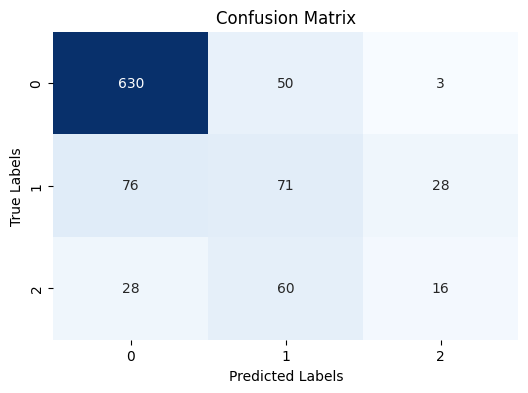


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 630/683 (92.24%)
Class 1: Correct Predictions / Total True Samples = 71/175 (40.57%)
Class 2: Correct Predictions / Total True Samples = 16/104 (15.38%)

Precision-Recall Curves:


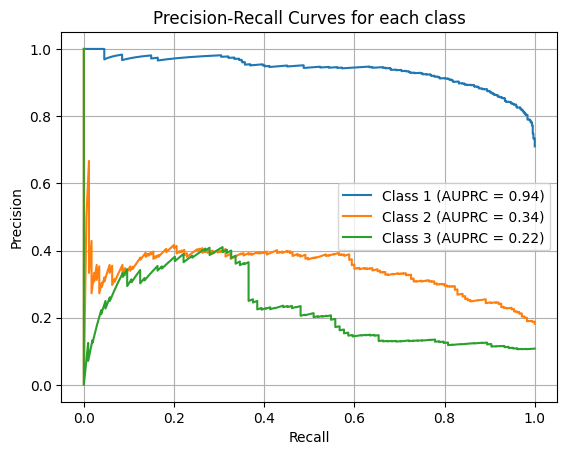


ROC Curves:


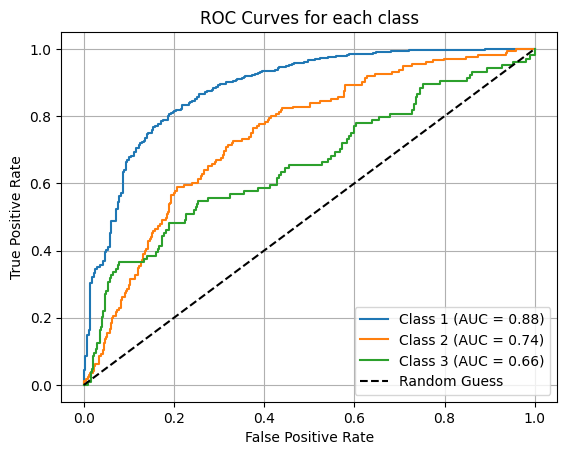


Mean F1 Score: 0.5000
Balanced Accuracy: 0.4940
Average AUPRC: 0.5001

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       683
           1       0.39      0.41      0.40       175
           2       0.34      0.15      0.21       104

    accuracy                           0.75       962
   macro avg       0.53      0.49      0.50       962
weighted avg       0.72      0.75      0.73       962

Fold No: 2
Epoch [1/100], Loss: 1.1339, Accuracy: 0.3687
Validation Loss: 1.3138, Validation Accuracy: 0.3097
Epoch [2/100], Loss: 1.1055, Accuracy: 0.4145
Validation Loss: 0.9740, Validation Accuracy: 0.4207
Epoch [3/100], Loss: 1.0928, Accuracy: 0.4425
Validation Loss: 1.1102, Validation Accuracy: 0.3872
Epoch [4/100], Loss: 1.0645, Accuracy: 0.4801
Validation Loss: 0.9641, Validation Accuracy: 0.4631
Epoch [5/100], Loss: 1.0393, Accuracy: 0.5280
Validation Loss: 0.9860, Validation Accuracy: 0.5200
Epoch [6/100], Los

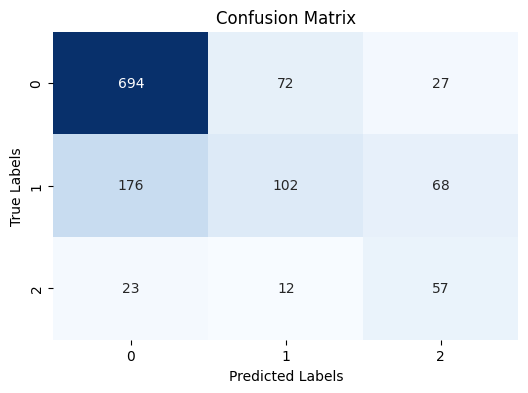


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 694/793 (87.52%)
Class 1: Correct Predictions / Total True Samples = 102/346 (29.48%)
Class 2: Correct Predictions / Total True Samples = 57/92 (61.96%)

Precision-Recall Curves:


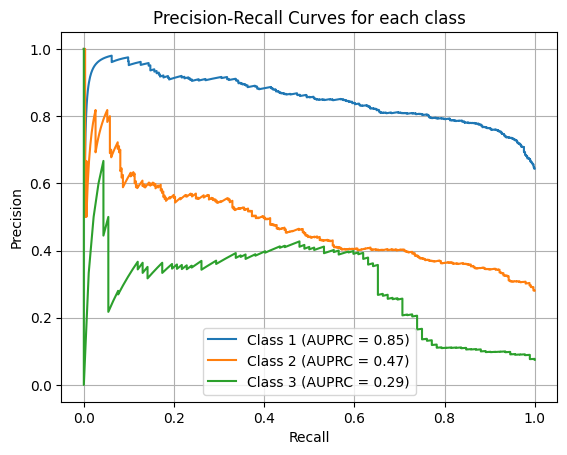


ROC Curves:


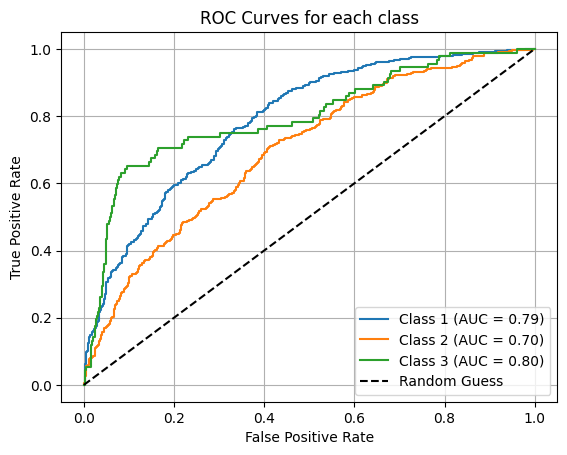


Mean F1 Score: 0.5580
Balanced Accuracy: 0.5965
Average AUPRC: 0.5407

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.82       793
           1       0.55      0.29      0.38       346
           2       0.38      0.62      0.47        92

    accuracy                           0.69      1231
   macro avg       0.57      0.60      0.56      1231
weighted avg       0.68      0.69      0.67      1231

Fold No: 3
Epoch [1/100], Loss: 1.1505, Accuracy: 0.3443
Validation Loss: 1.0235, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1308, Accuracy: 0.3488
Validation Loss: 0.9842, Validation Accuracy: 0.3333
Epoch [3/100], Loss: 1.1244, Accuracy: 0.3707
Validation Loss: 1.0889, Validation Accuracy: 0.4506
Epoch [4/100], Loss: 1.1002, Accuracy: 0.4098
Validation Loss: 0.9763, Validation Accuracy: 0.3647
Epoch [5/100], Loss: 1.0735, Accuracy: 0.4581
Validation Loss: 1.2187, Validation Accuracy: 0.4349
Epoch [6/100], Los

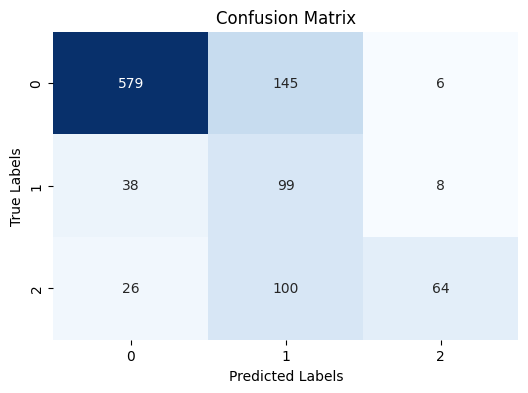


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 579/730 (79.32%)
Class 1: Correct Predictions / Total True Samples = 99/145 (68.28%)
Class 2: Correct Predictions / Total True Samples = 64/190 (33.68%)

Precision-Recall Curves:


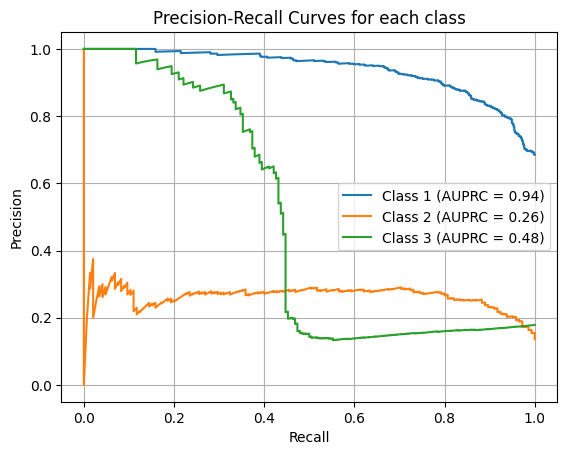


ROC Curves:


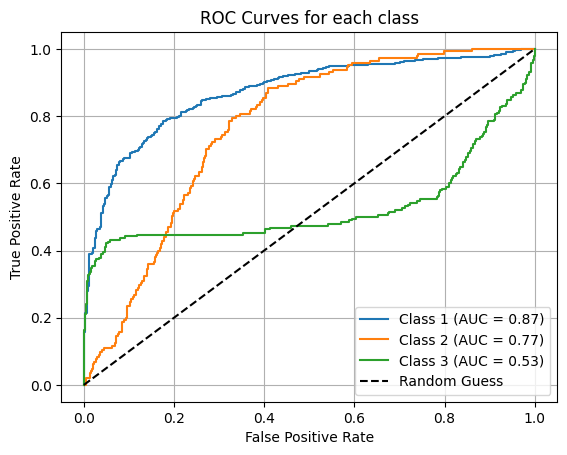


Mean F1 Score: 0.5753
Balanced Accuracy: 0.6043
Average AUPRC: 0.5604

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       730
           1       0.29      0.68      0.40       145
           2       0.82      0.34      0.48       190

    accuracy                           0.70      1065
   macro avg       0.67      0.60      0.58      1065
weighted avg       0.80      0.70      0.72      1065

Fold No: 4
Epoch [1/100], Loss: 1.1581, Accuracy: 0.3441
Validation Loss: 1.0307, Validation Accuracy: 0.4345
Epoch [2/100], Loss: 1.1256, Accuracy: 0.3567
Validation Loss: 1.1791, Validation Accuracy: 0.3388
Epoch [3/100], Loss: 1.1146, Accuracy: 0.3577
Validation Loss: 1.0519, Validation Accuracy: 0.3522
Epoch [4/100], Loss: 1.1073, Accuracy: 0.3957
Validation Loss: 1.0593, Validation Accuracy: 0.4564
Epoch [5/100], Loss: 1.1196, Accuracy: 0.3674
Validation Loss: 1.1925, Validation Accuracy: 0.3607
Epoch [6/100], Los

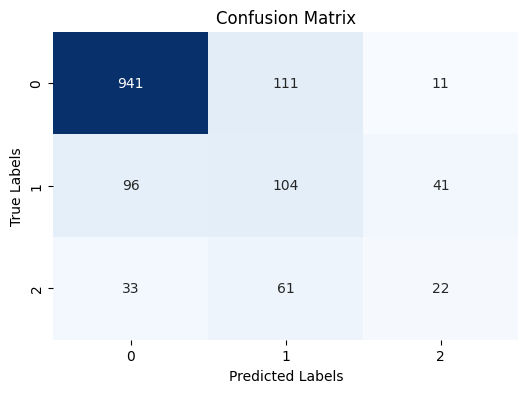


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 941/1063 (88.52%)
Class 1: Correct Predictions / Total True Samples = 104/241 (43.15%)
Class 2: Correct Predictions / Total True Samples = 22/116 (18.97%)

Precision-Recall Curves:


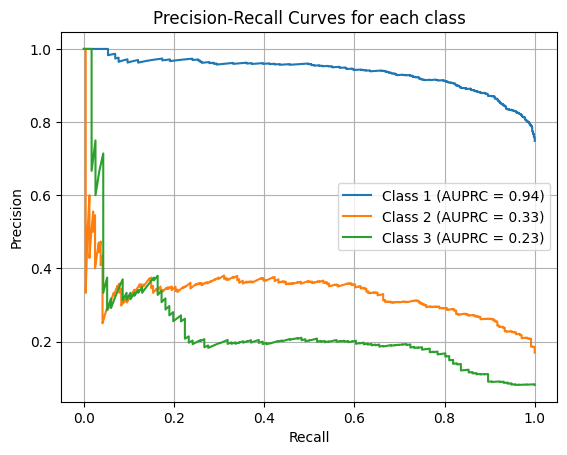


ROC Curves:


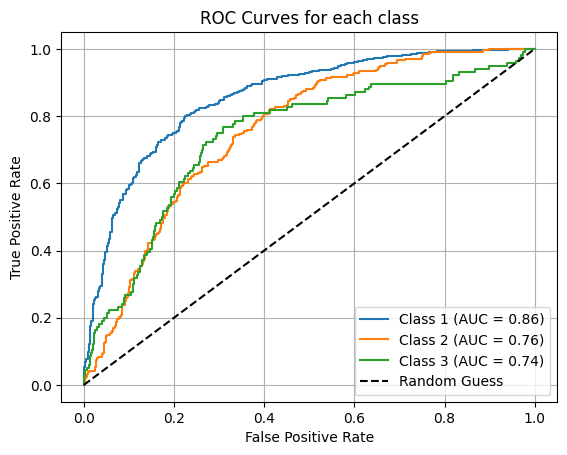


Mean F1 Score: 0.5054
Balanced Accuracy: 0.5021
Average AUPRC: 0.4988

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1063
           1       0.38      0.43      0.40       241
           2       0.30      0.19      0.23       116

    accuracy                           0.75      1420
   macro avg       0.52      0.50      0.51      1420
weighted avg       0.75      0.75      0.75      1420

Fold No: 5
Epoch [1/100], Loss: 1.1605, Accuracy: 0.3290
Validation Loss: 1.0938, Validation Accuracy: 0.4494
Epoch [2/100], Loss: 1.0912, Accuracy: 0.4206
Validation Loss: 1.1279, Validation Accuracy: 0.4063
Epoch [3/100], Loss: 1.0604, Accuracy: 0.4810
Validation Loss: 0.9421, Validation Accuracy: 0.4933
Epoch [4/100], Loss: 1.0171, Accuracy: 0.5518
Validation Loss: 1.0823, Validation Accuracy: 0.4342
Epoch [5/100], Loss: 0.9935, Accuracy: 0.5881
Validation Loss: 0.9712, Validation Accuracy: 0.5049
Epoch [6/100], Los

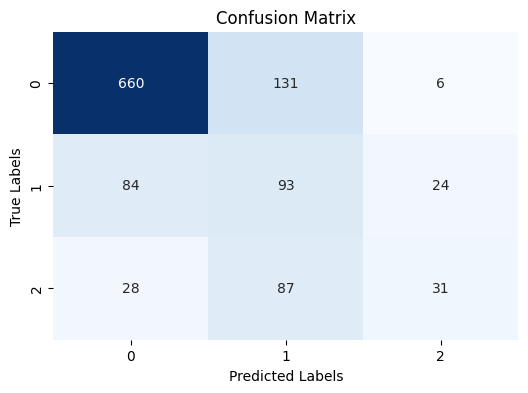


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 660/797 (82.81%)
Class 1: Correct Predictions / Total True Samples = 93/201 (46.27%)
Class 2: Correct Predictions / Total True Samples = 31/146 (21.23%)

Precision-Recall Curves:


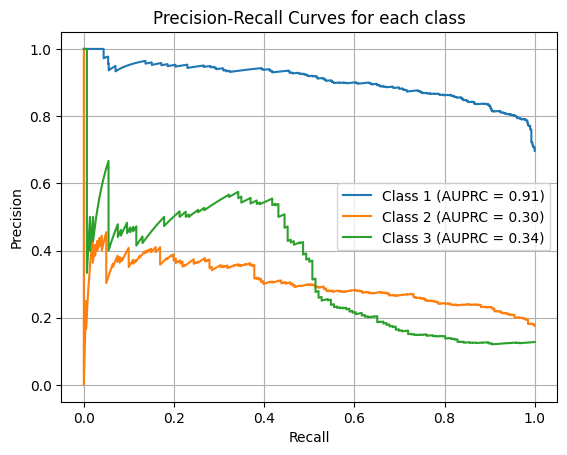


ROC Curves:


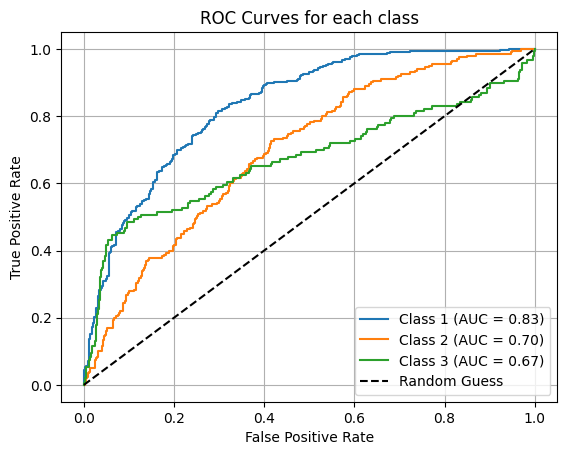


Mean F1 Score: 0.5014
Balanced Accuracy: 0.5010
Average AUPRC: 0.5151

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       797
           1       0.30      0.46      0.36       201
           2       0.51      0.21      0.30       146

    accuracy                           0.69      1144
   macro avg       0.55      0.50      0.50      1144
weighted avg       0.71      0.69      0.69      1144

Accuracy for each fold: [np.float64(0.4939872036211714), np.float64(0.5965068448361887), np.float64(0.6042504702947733), np.float64(0.5021403072991869), np.float64(0.5010402431731957)]
AUPRC for each fold: [np.float64(0.5001006430443408), np.float64(0.5406692076292711), np.float64(0.5603514645404805), np.float64(0.4987881284095556), np.float64(0.5151234709469135)]
Average AUPRC across all folds: 0.5230065829141123
Average Balanced Accuracy across all folds: 0.5395850138449031
___________________________________________

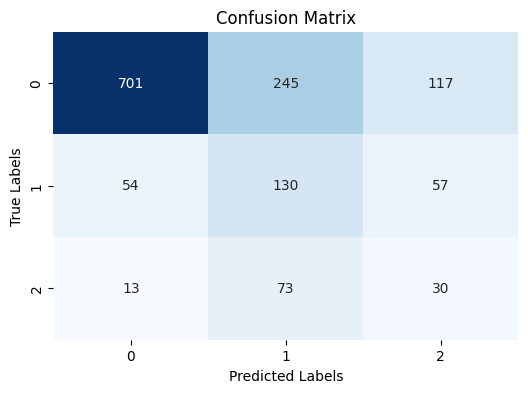


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 701/1063 (65.95%)
Class 1: Correct Predictions / Total True Samples = 130/241 (53.94%)
Class 2: Correct Predictions / Total True Samples = 30/116 (25.86%)

Precision-Recall Curves:


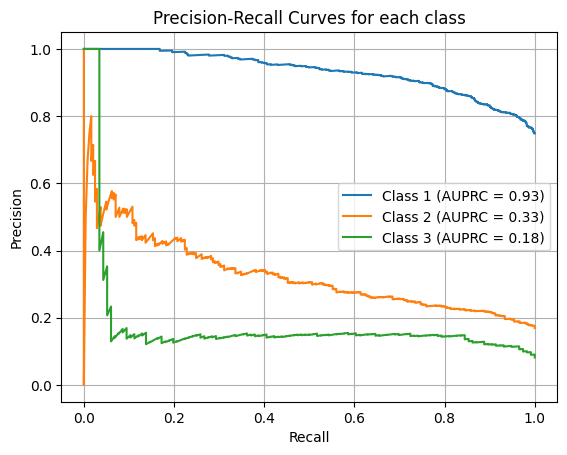


ROC Curves:


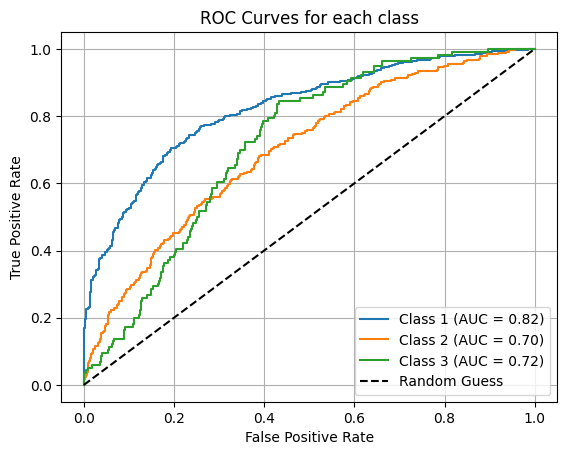


Mean F1 Score: 0.4435
Balanced Accuracy: 0.4858
Average AUPRC: 0.4775

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.66      0.77      1063
           1       0.29      0.54      0.38       241
           2       0.15      0.26      0.19       116

    accuracy                           0.61      1420
   macro avg       0.45      0.49      0.44      1420
weighted avg       0.74      0.61      0.65      1420

Fold No: 2
Epoch [1/100], Loss: 1.1294, Accuracy: 0.3279
Validation Loss: 1.0976, Validation Accuracy: 0.3361
Epoch [2/100], Loss: 1.1100, Accuracy: 0.3645
Validation Loss: 1.0830, Validation Accuracy: 0.3351
Epoch [3/100], Loss: 1.0937, Accuracy: 0.3902
Validation Loss: 1.0776, Validation Accuracy: 0.3629
Epoch [4/100], Loss: 1.0864, Accuracy: 0.4206
Validation Loss: 1.0906, Validation Accuracy: 0.3535
Epoch [5/100], Loss: 1.0687, Accuracy: 0.4424
Validation Loss: 1.0874, Validation Accuracy: 0.3658
Epoch [6/100], Los

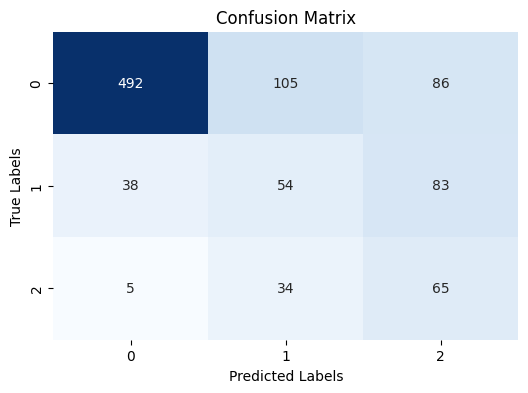


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 492/683 (72.04%)
Class 1: Correct Predictions / Total True Samples = 54/175 (30.86%)
Class 2: Correct Predictions / Total True Samples = 65/104 (62.50%)

Precision-Recall Curves:


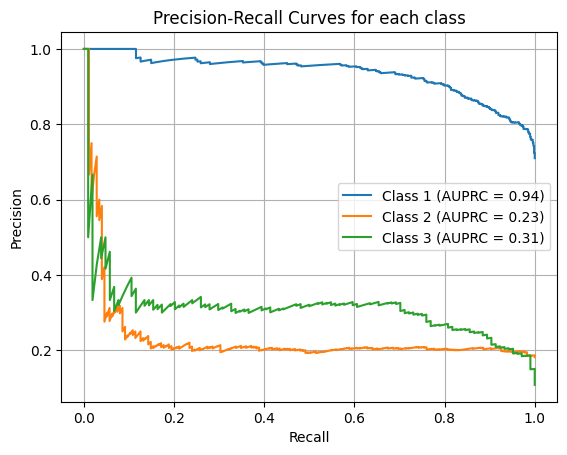


ROC Curves:


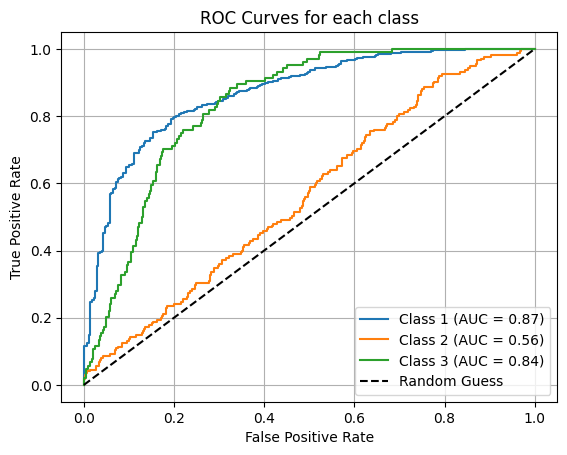


Mean F1 Score: 0.4953
Balanced Accuracy: 0.5513
Average AUPRC: 0.4933

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.72      0.81       683
           1       0.28      0.31      0.29       175
           2       0.28      0.62      0.38       104

    accuracy                           0.64       962
   macro avg       0.49      0.55      0.50       962
weighted avg       0.73      0.64      0.67       962

Fold No: 3
Epoch [1/100], Loss: 1.1223, Accuracy: 0.3333
Validation Loss: 1.0661, Validation Accuracy: 0.4035
Epoch [2/100], Loss: 1.1082, Accuracy: 0.3653
Validation Loss: 1.0800, Validation Accuracy: 0.4041
Epoch [3/100], Loss: 1.0883, Accuracy: 0.4134
Validation Loss: 1.0641, Validation Accuracy: 0.4288
Epoch [4/100], Loss: 1.0958, Accuracy: 0.4209
Validation Loss: 1.0554, Validation Accuracy: 0.4079
Epoch [5/100], Loss: 1.0776, Accuracy: 0.4510
Validation Loss: 1.0579, Validation Accuracy: 0.4519
Epoch [6/100], Los

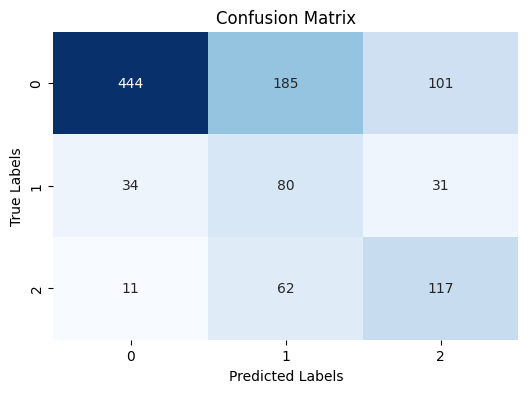


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 444/730 (60.82%)
Class 1: Correct Predictions / Total True Samples = 80/145 (55.17%)
Class 2: Correct Predictions / Total True Samples = 117/190 (61.58%)

Precision-Recall Curves:


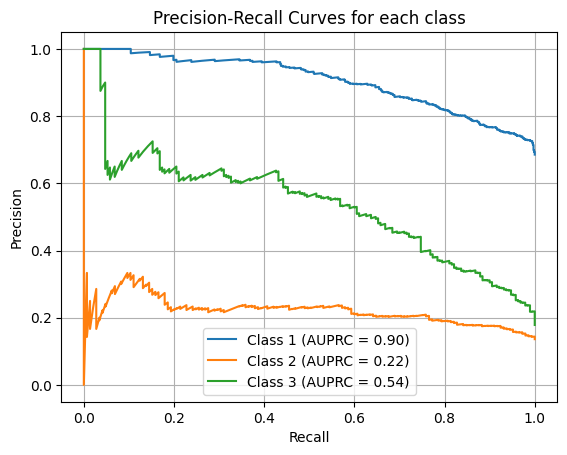


ROC Curves:


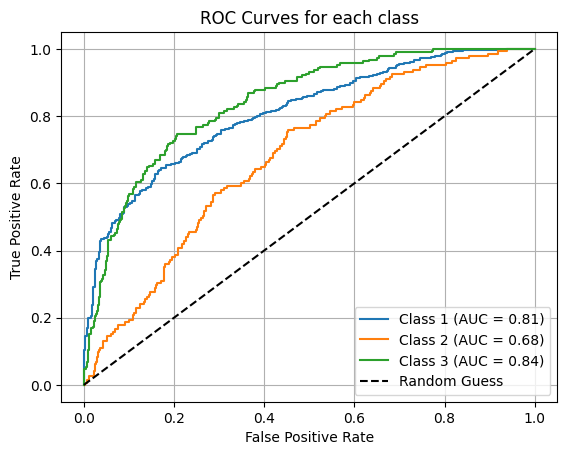


Mean F1 Score: 0.5335
Balanced Accuracy: 0.5919
Average AUPRC: 0.5535

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.61      0.73       730
           1       0.24      0.55      0.34       145
           2       0.47      0.62      0.53       190

    accuracy                           0.60      1065
   macro avg       0.54      0.59      0.53      1065
weighted avg       0.74      0.60      0.64      1065

Fold No: 4
Epoch [1/100], Loss: 1.1221, Accuracy: 0.3270
Validation Loss: 1.0732, Validation Accuracy: 0.4255
Epoch [2/100], Loss: 1.1079, Accuracy: 0.3443
Validation Loss: 1.0658, Validation Accuracy: 0.4396
Epoch [3/100], Loss: 1.1068, Accuracy: 0.3625
Validation Loss: 1.0486, Validation Accuracy: 0.4590
Epoch [4/100], Loss: 1.0932, Accuracy: 0.4117
Validation Loss: 1.0667, Validation Accuracy: 0.4790
Epoch [5/100], Loss: 1.0878, Accuracy: 0.4180
Validation Loss: 1.0634, Validation Accuracy: 0.4767
Epoch [6/100], Los

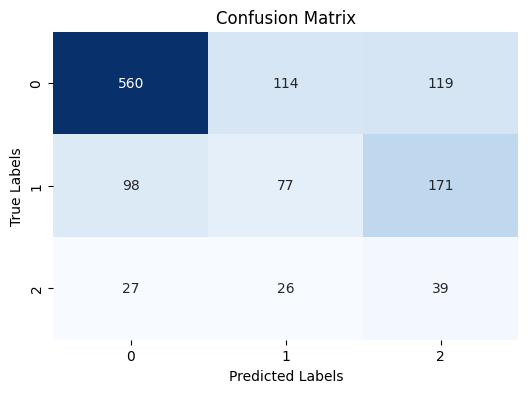


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 560/793 (70.62%)
Class 1: Correct Predictions / Total True Samples = 77/346 (22.25%)
Class 2: Correct Predictions / Total True Samples = 39/92 (42.39%)

Precision-Recall Curves:


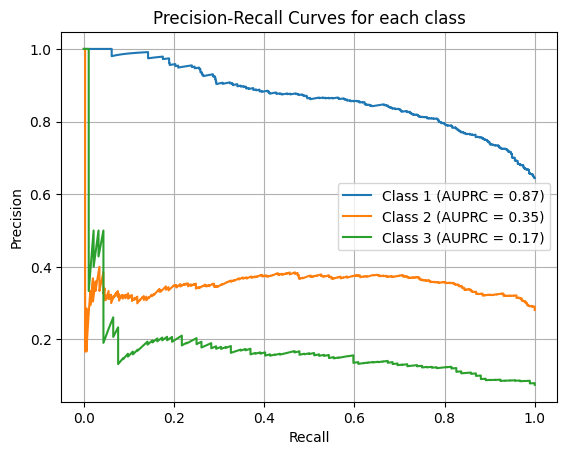


ROC Curves:


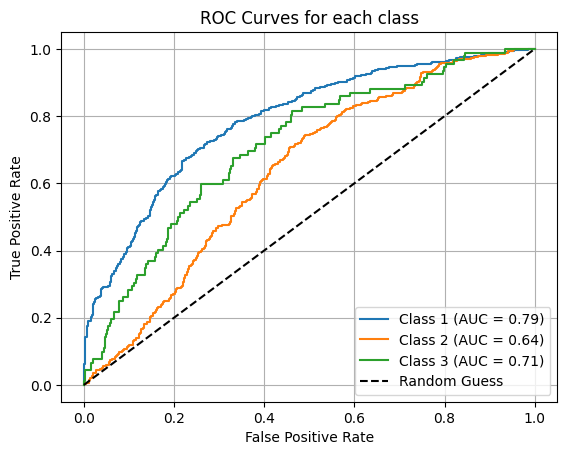


Mean F1 Score: 0.4055
Balanced Accuracy: 0.4509
Average AUPRC: 0.4626

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       793
           1       0.35      0.22      0.27       346
           2       0.12      0.42      0.19        92

    accuracy                           0.55      1231
   macro avg       0.43      0.45      0.41      1231
weighted avg       0.64      0.55      0.58      1231

Fold No: 5
Epoch [1/100], Loss: 1.1360, Accuracy: 0.3220
Validation Loss: 1.1077, Validation Accuracy: 0.3588
Epoch [2/100], Loss: 1.1078, Accuracy: 0.3707
Validation Loss: 1.0519, Validation Accuracy: 0.3843
Epoch [3/100], Loss: 1.0957, Accuracy: 0.4049
Validation Loss: 1.0793, Validation Accuracy: 0.4183
Epoch [4/100], Loss: 1.0812, Accuracy: 0.4203
Validation Loss: 1.0418, Validation Accuracy: 0.3986
Epoch [5/100], Loss: 1.0611, Accuracy: 0.4618
Validation Loss: 1.0470, Validation Accuracy: 0.4592
Epoch [6/100], Los

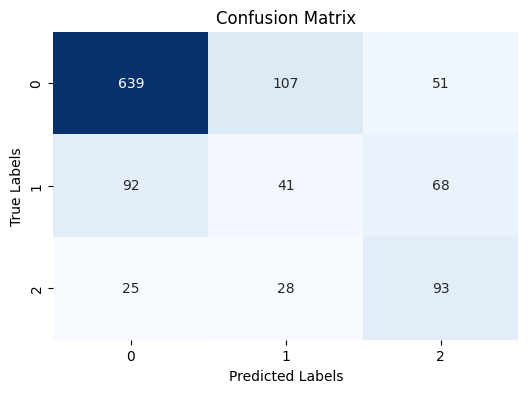


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 639/797 (80.18%)
Class 1: Correct Predictions / Total True Samples = 41/201 (20.40%)
Class 2: Correct Predictions / Total True Samples = 93/146 (63.70%)

Precision-Recall Curves:


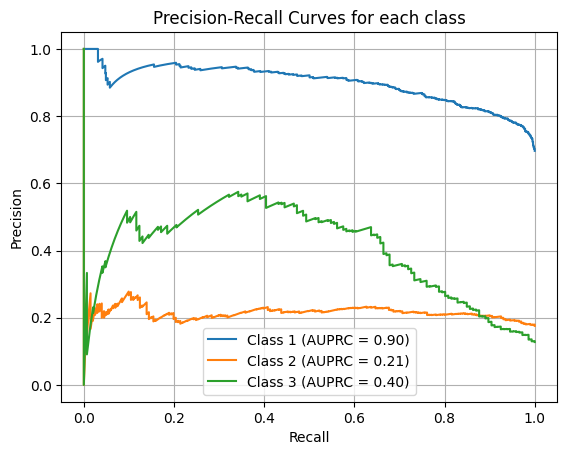


ROC Curves:


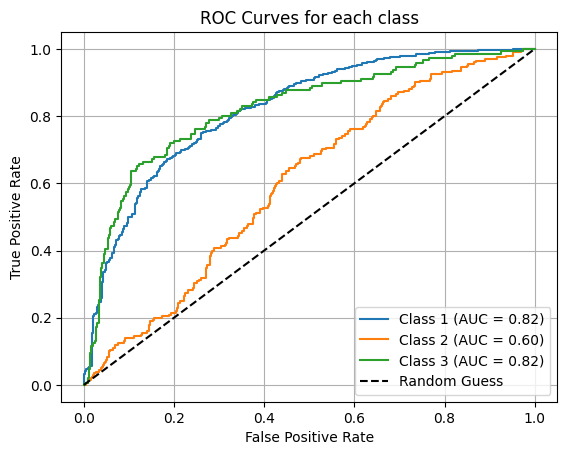


Mean F1 Score: 0.5200
Balanced Accuracy: 0.5476
Average AUPRC: 0.5046

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       797
           1       0.23      0.20      0.22       201
           2       0.44      0.64      0.52       146

    accuracy                           0.68      1144
   macro avg       0.51      0.55      0.52      1144
weighted avg       0.69      0.68      0.68      1144

Accuracy for each fold: [np.float64(0.4858313837347144), np.float64(0.5513076064979433), np.float64(0.5919109298991456), np.float64(0.4508784876380738), np.float64(0.5475743293581193)]
AUPRC for each fold: [np.float64(0.47745578278813056), np.float64(0.4933076785895392), np.float64(0.55346944319072), np.float64(0.4626023699959971), np.float64(0.5046489776861627)]
Average AUPRC across all folds: 0.4982968504501099
Average Balanced Accuracy across all folds: 0.5255005474255994
____________________________________________

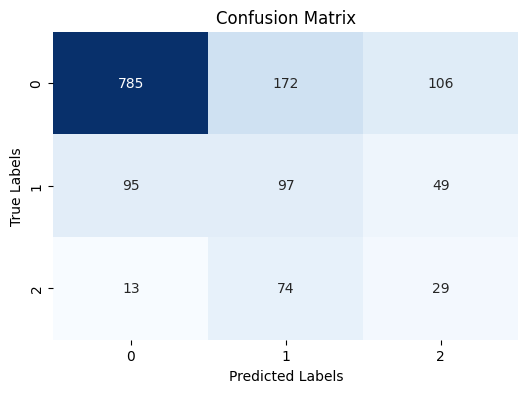


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 785/1063 (73.85%)
Class 1: Correct Predictions / Total True Samples = 97/241 (40.25%)
Class 2: Correct Predictions / Total True Samples = 29/116 (25.00%)

Precision-Recall Curves:


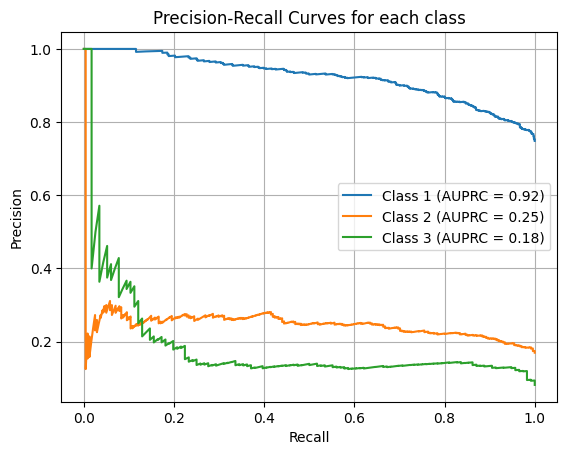


ROC Curves:


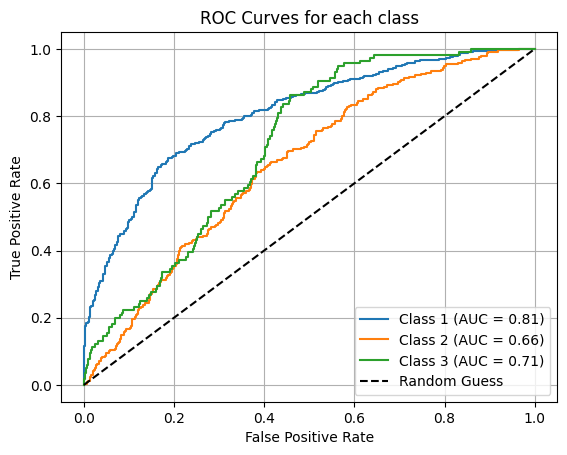


Mean F1 Score: 0.4427
Balanced Accuracy: 0.4637
Average AUPRC: 0.4511

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      1063
           1       0.28      0.40      0.33       241
           2       0.16      0.25      0.19       116

    accuracy                           0.64      1420
   macro avg       0.44      0.46      0.44      1420
weighted avg       0.72      0.64      0.67      1420

Fold No: 2
Epoch [1/100], Loss: 1.1126, Accuracy: 0.3561
Validation Loss: 1.0774, Validation Accuracy: 0.3398
Epoch [2/100], Loss: 1.0920, Accuracy: 0.4182
Validation Loss: 1.0884, Validation Accuracy: 0.3822
Epoch [3/100], Loss: 1.0806, Accuracy: 0.4303
Validation Loss: 1.0473, Validation Accuracy: 0.3971
Epoch [4/100], Loss: 1.0598, Accuracy: 0.4894
Validation Loss: 1.0632, Validation Accuracy: 0.4139
Epoch [5/100], Loss: 1.0477, Accuracy: 0.5038
Validation Loss: 0.9992, Validation Accuracy: 0.4410
Epoch [6/100], Los

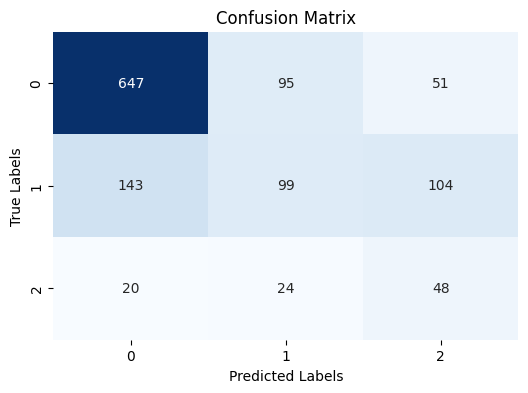


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 647/793 (81.59%)
Class 1: Correct Predictions / Total True Samples = 99/346 (28.61%)
Class 2: Correct Predictions / Total True Samples = 48/92 (52.17%)

Precision-Recall Curves:


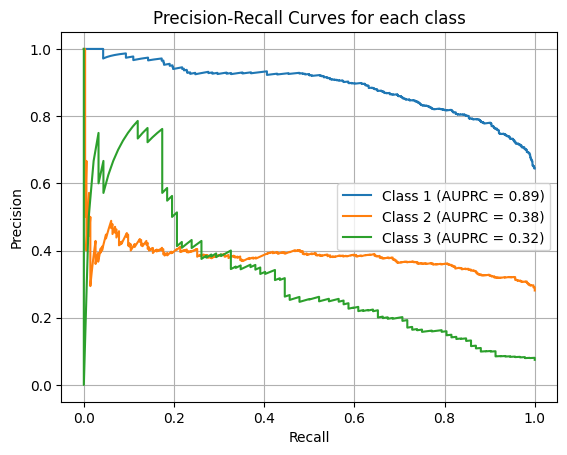


ROC Curves:


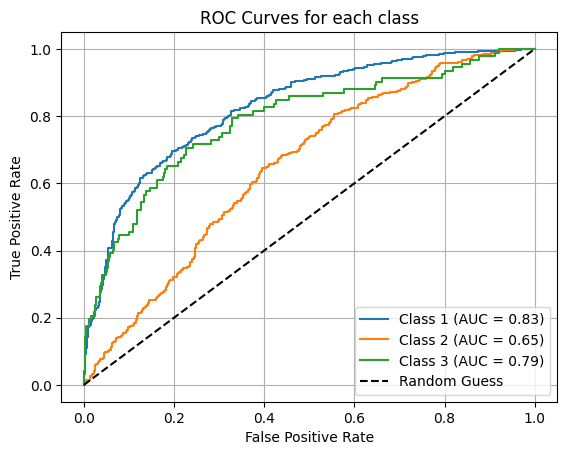


Mean F1 Score: 0.4946
Balanced Accuracy: 0.5413
Average AUPRC: 0.5307

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       793
           1       0.45      0.29      0.35       346
           2       0.24      0.52      0.33        92

    accuracy                           0.65      1231
   macro avg       0.50      0.54      0.49      1231
weighted avg       0.66      0.65      0.64      1231

Fold No: 3
Epoch [1/100], Loss: 1.1085, Accuracy: 0.3642
Validation Loss: 1.1303, Validation Accuracy: 0.3483
Epoch [2/100], Loss: 1.0878, Accuracy: 0.4163
Validation Loss: 1.1166, Validation Accuracy: 0.3648
Epoch [3/100], Loss: 1.0827, Accuracy: 0.4203
Validation Loss: 1.0764, Validation Accuracy: 0.4022
Epoch [4/100], Loss: 1.0690, Accuracy: 0.4699
Validation Loss: 1.0472, Validation Accuracy: 0.4202
Epoch [5/100], Loss: 1.0635, Accuracy: 0.4805
Validation Loss: 1.0328, Validation Accuracy: 0.4217
Epoch [6/100], Los

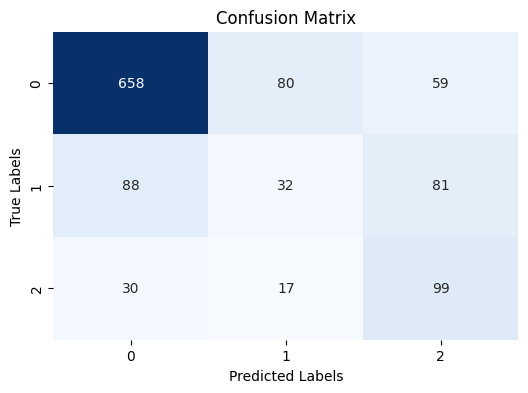


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 658/797 (82.56%)
Class 1: Correct Predictions / Total True Samples = 32/201 (15.92%)
Class 2: Correct Predictions / Total True Samples = 99/146 (67.81%)

Precision-Recall Curves:


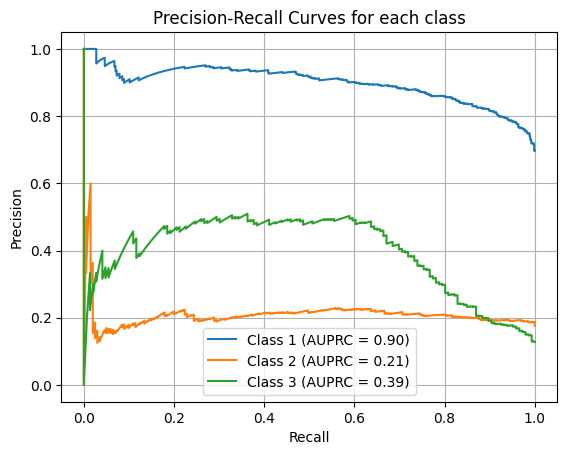


ROC Curves:


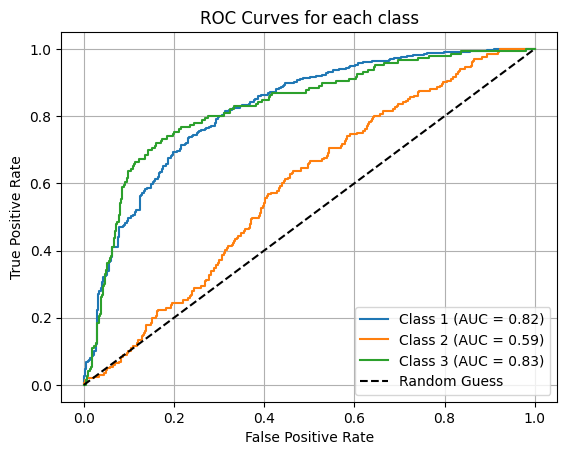


Mean F1 Score: 0.5149
Balanced Accuracy: 0.5543
Average AUPRC: 0.4990

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       797
           1       0.25      0.16      0.19       201
           2       0.41      0.68      0.51       146

    accuracy                           0.69      1144
   macro avg       0.50      0.55      0.51      1144
weighted avg       0.69      0.69      0.68      1144

Fold No: 4
Epoch [1/100], Loss: 1.1131, Accuracy: 0.3476
Validation Loss: 1.1372, Validation Accuracy: 0.3109
Epoch [2/100], Loss: 1.0913, Accuracy: 0.3953
Validation Loss: 1.0244, Validation Accuracy: 0.3478
Epoch [3/100], Loss: 1.0901, Accuracy: 0.4221
Validation Loss: 1.0966, Validation Accuracy: 0.3998
Epoch [4/100], Loss: 1.0843, Accuracy: 0.4179
Validation Loss: 1.0519, Validation Accuracy: 0.4178
Epoch [5/100], Loss: 1.0690, Accuracy: 0.4606
Validation Loss: 1.0638, Validation Accuracy: 0.4303
Epoch [6/100], Los

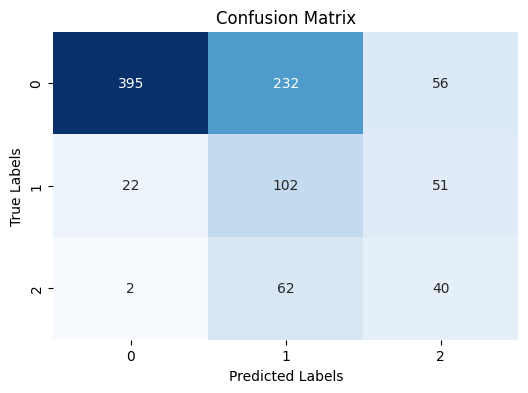


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 395/683 (57.83%)
Class 1: Correct Predictions / Total True Samples = 102/175 (58.29%)
Class 2: Correct Predictions / Total True Samples = 40/104 (38.46%)

Precision-Recall Curves:


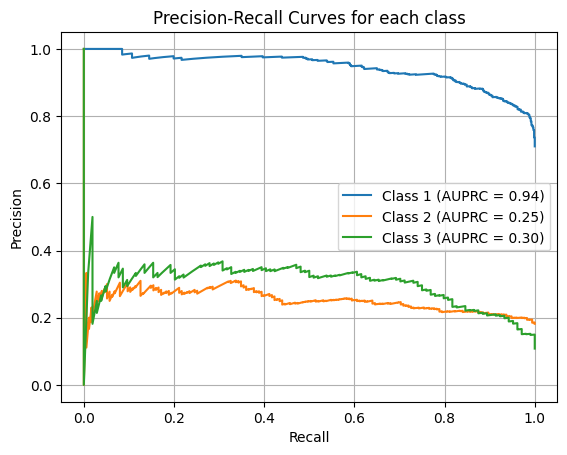


ROC Curves:


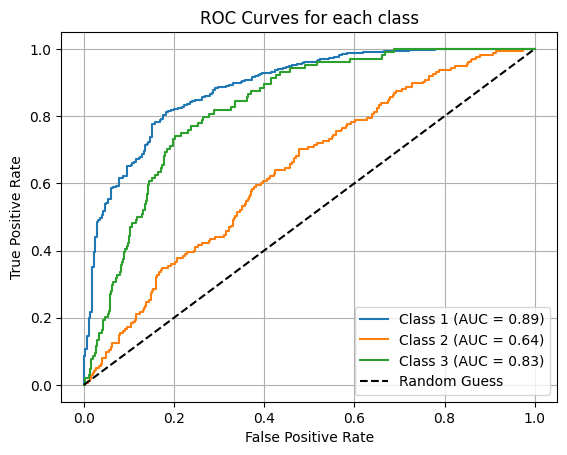


Mean F1 Score: 0.4643
Balanced Accuracy: 0.5153
Average AUPRC: 0.4985

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       683
           1       0.26      0.58      0.36       175
           2       0.27      0.38      0.32       104

    accuracy                           0.56       962
   macro avg       0.49      0.52      0.46       962
weighted avg       0.75      0.56      0.61       962

Fold No: 5
Epoch [1/100], Loss: 1.1121, Accuracy: 0.3625
Validation Loss: 1.1004, Validation Accuracy: 0.3945
Epoch [2/100], Loss: 1.1034, Accuracy: 0.3719
Validation Loss: 1.0604, Validation Accuracy: 0.4345
Epoch [3/100], Loss: 1.0893, Accuracy: 0.4143
Validation Loss: 1.0365, Validation Accuracy: 0.5063
Epoch [4/100], Loss: 1.0769, Accuracy: 0.4435
Validation Loss: 1.0207, Validation Accuracy: 0.4494
Epoch [5/100], Loss: 1.0703, Accuracy: 0.4529
Validation Loss: 1.0227, Validation Accuracy: 0.4986
Epoch [6/100], Los

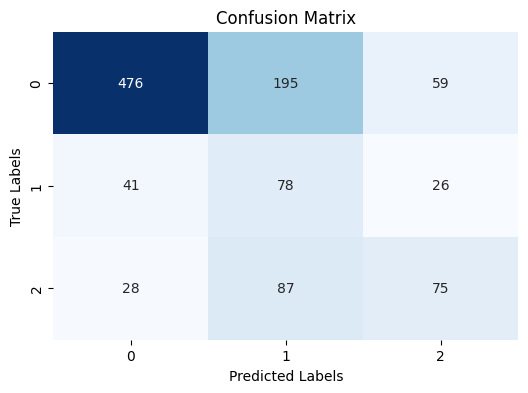


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 476/730 (65.21%)
Class 1: Correct Predictions / Total True Samples = 78/145 (53.79%)
Class 2: Correct Predictions / Total True Samples = 75/190 (39.47%)

Precision-Recall Curves:


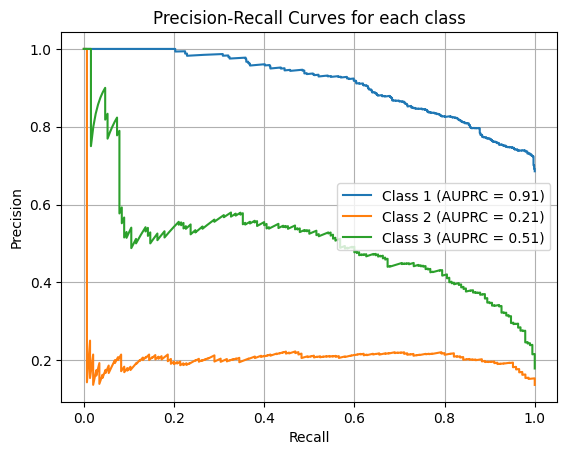


ROC Curves:


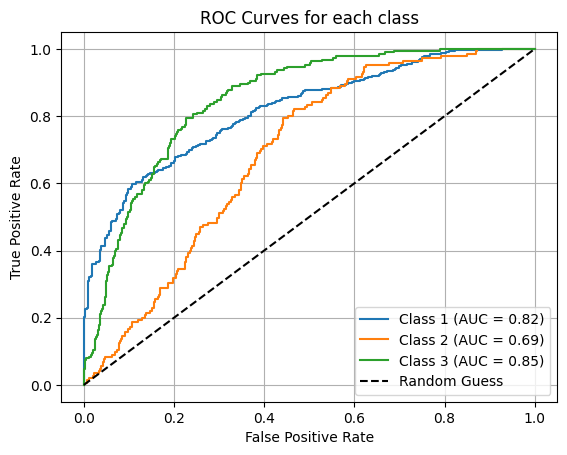


Mean F1 Score: 0.4947
Balanced Accuracy: 0.5282
Average AUPRC: 0.5416

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.65      0.75       730
           1       0.22      0.54      0.31       145
           2       0.47      0.39      0.43       190

    accuracy                           0.59      1065
   macro avg       0.52      0.53      0.49      1065
weighted avg       0.71      0.59      0.63      1065

Accuracy for each fold: [np.float64(0.46365521261494064), np.float64(0.5412517756895411), np.float64(0.5542940522746209), np.float64(0.5152678068637072), np.float64(0.5282408903695233)]
AUPRC for each fold: [np.float64(0.451148255687057), np.float64(0.5307374943702107), np.float64(0.4990084455544474), np.float64(0.4984876107568416), np.float64(0.5416496302864934)]
Average AUPRC across all folds: 0.50420628733101
Average Balanced Accuracy across all folds: 0.5205419475624666
_____________________________________________

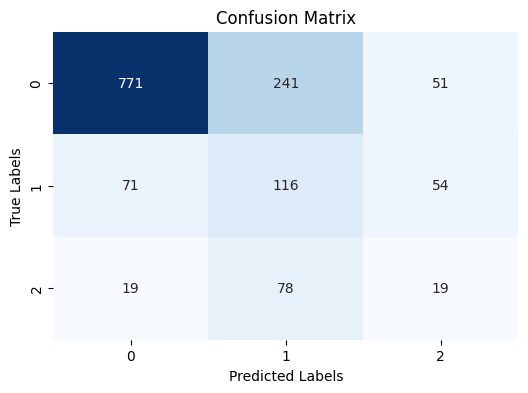


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 771/1063 (72.53%)
Class 1: Correct Predictions / Total True Samples = 116/241 (48.13%)
Class 2: Correct Predictions / Total True Samples = 19/116 (16.38%)

Precision-Recall Curves:


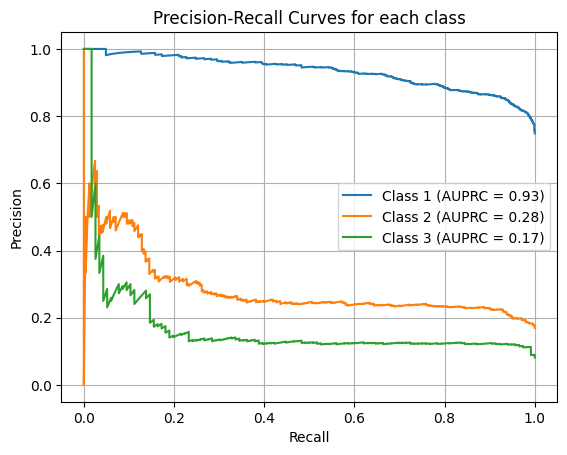


ROC Curves:


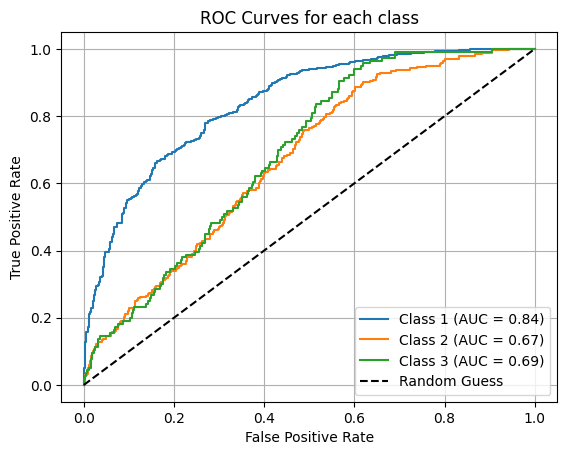


Mean F1 Score: 0.4343
Balanced Accuracy: 0.4568
Average AUPRC: 0.4606

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1063
           1       0.27      0.48      0.34       241
           2       0.15      0.16      0.16       116

    accuracy                           0.64      1420
   macro avg       0.44      0.46      0.43      1420
weighted avg       0.73      0.64      0.67      1420

Fold No: 2
Epoch [1/100], Loss: 1.0959, Accuracy: 0.4394
Validation Loss: 1.0024, Validation Accuracy: 0.4056
Epoch [2/100], Loss: 1.0381, Accuracy: 0.5129
Validation Loss: 1.0252, Validation Accuracy: 0.4798
Epoch [3/100], Loss: 1.0383, Accuracy: 0.5174
Validation Loss: 1.0513, Validation Accuracy: 0.4498
Epoch [4/100], Loss: 1.0398, Accuracy: 0.5235
Validation Loss: 0.9566, Validation Accuracy: 0.4148
Epoch [5/100], Loss: 1.0139, Accuracy: 0.5697
Validation Loss: 1.0256, Validation Accuracy: 0.4850
Epoch [6/100], Los

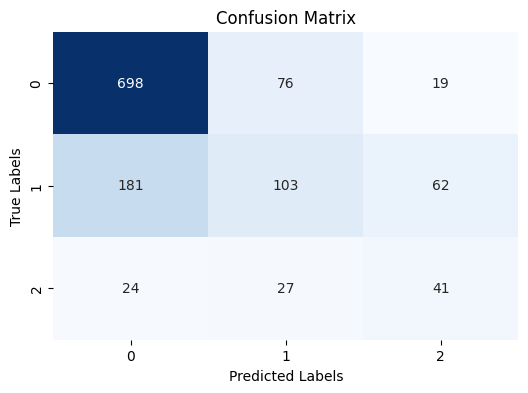


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 698/793 (88.02%)
Class 1: Correct Predictions / Total True Samples = 103/346 (29.77%)
Class 2: Correct Predictions / Total True Samples = 41/92 (44.57%)

Precision-Recall Curves:


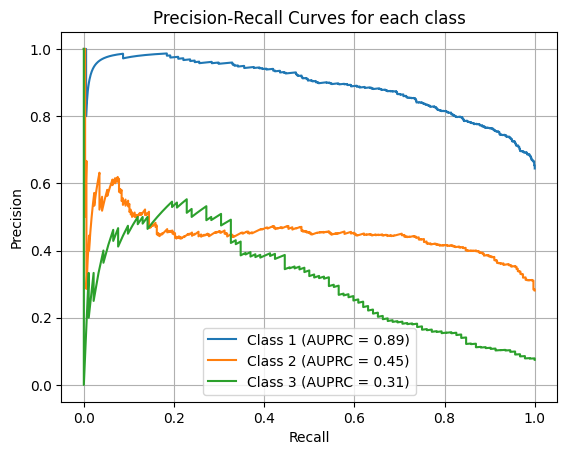


ROC Curves:


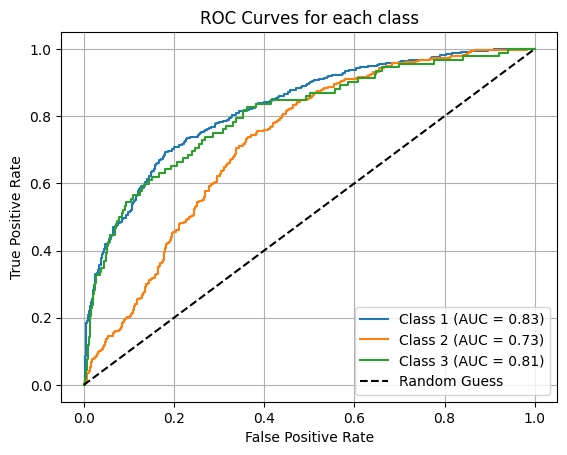


Mean F1 Score: 0.5265
Balanced Accuracy: 0.5412
Average AUPRC: 0.5492

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       793
           1       0.50      0.30      0.37       346
           2       0.34      0.45      0.38        92

    accuracy                           0.68      1231
   macro avg       0.54      0.54      0.53      1231
weighted avg       0.66      0.68      0.66      1231

Fold No: 3
Epoch [1/100], Loss: 1.1231, Accuracy: 0.3886
Validation Loss: 1.0695, Validation Accuracy: 0.3832
Epoch [2/100], Loss: 1.0862, Accuracy: 0.4211
Validation Loss: 1.0434, Validation Accuracy: 0.4654
Epoch [3/100], Loss: 1.0667, Accuracy: 0.4504
Validation Loss: 1.0267, Validation Accuracy: 0.4702
Epoch [4/100], Loss: 1.0426, Accuracy: 0.5057
Validation Loss: 1.0372, Validation Accuracy: 0.5063
Epoch [5/100], Loss: 1.0368, Accuracy: 0.5146
Validation Loss: 1.0483, Validation Accuracy: 0.4791
Epoch [6/100], Los

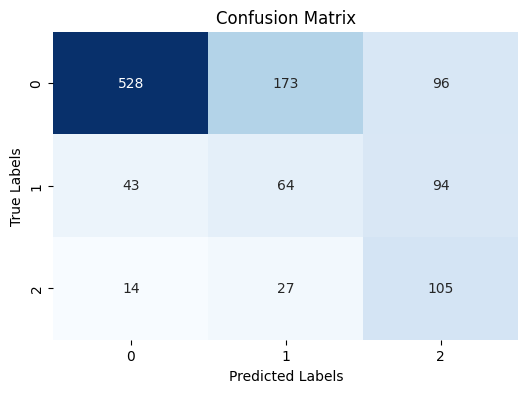


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 528/797 (66.25%)
Class 1: Correct Predictions / Total True Samples = 64/201 (31.84%)
Class 2: Correct Predictions / Total True Samples = 105/146 (71.92%)

Precision-Recall Curves:


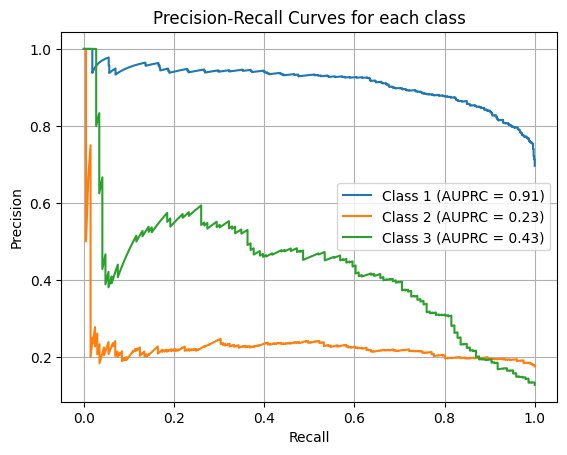


ROC Curves:


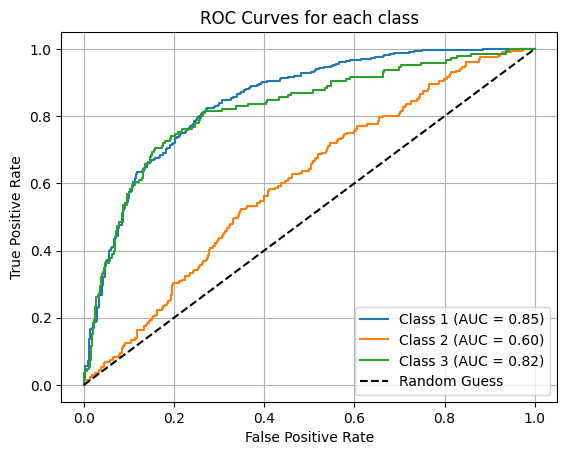


Mean F1 Score: 0.5052
Balanced Accuracy: 0.5667
Average AUPRC: 0.5228

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.66      0.76       797
           1       0.24      0.32      0.28       201
           2       0.36      0.72      0.48       146

    accuracy                           0.61      1144
   macro avg       0.50      0.57      0.51      1144
weighted avg       0.72      0.61      0.64      1144

Fold No: 4
Epoch [1/100], Loss: 1.1288, Accuracy: 0.3675
Validation Loss: 1.0975, Validation Accuracy: 0.3791
Epoch [2/100], Loss: 1.1053, Accuracy: 0.3729
Validation Loss: 1.0429, Validation Accuracy: 0.4879
Epoch [3/100], Loss: 1.0949, Accuracy: 0.4220
Validation Loss: 1.0832, Validation Accuracy: 0.4943
Epoch [4/100], Loss: 1.0827, Accuracy: 0.4498
Validation Loss: 0.9564, Validation Accuracy: 0.4165
Epoch [5/100], Loss: 1.0747, Accuracy: 0.4476
Validation Loss: 1.0342, Validation Accuracy: 0.4723
Epoch [6/100], Los

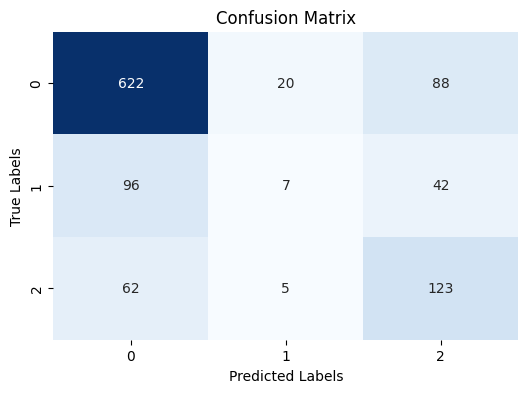


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 622/730 (85.21%)
Class 1: Correct Predictions / Total True Samples = 7/145 (4.83%)
Class 2: Correct Predictions / Total True Samples = 123/190 (64.74%)

Precision-Recall Curves:


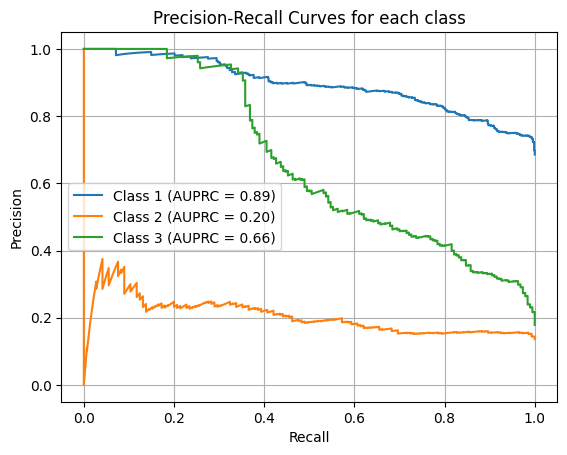


ROC Curves:


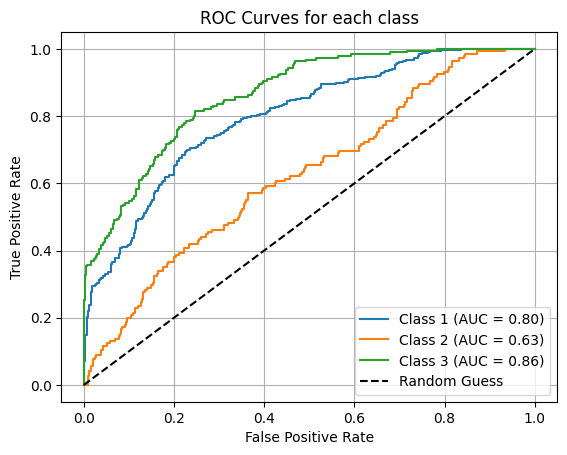


Mean F1 Score: 0.4861
Balanced Accuracy: 0.5159
Average AUPRC: 0.5855

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       730
           1       0.22      0.05      0.08       145
           2       0.49      0.65      0.56       190

    accuracy                           0.71      1065
   macro avg       0.50      0.52      0.49      1065
weighted avg       0.66      0.71      0.67      1065

Fold No: 5
Epoch [1/100], Loss: 1.1603, Accuracy: 0.4011
Validation Loss: 1.1550, Validation Accuracy: 0.4263
Epoch [2/100], Loss: 1.0870, Accuracy: 0.4379
Validation Loss: 0.9979, Validation Accuracy: 0.4798
Epoch [3/100], Loss: 1.0773, Accuracy: 0.4614
Validation Loss: 1.0876, Validation Accuracy: 0.4645
Epoch [4/100], Loss: 1.0756, Accuracy: 0.4360
Validation Loss: 1.0613, Validation Accuracy: 0.4929
Epoch [5/100], Loss: 1.0639, Accuracy: 0.4661
Validation Loss: 1.0193, Validation Accuracy: 0.5350
Epoch [6/100], Los

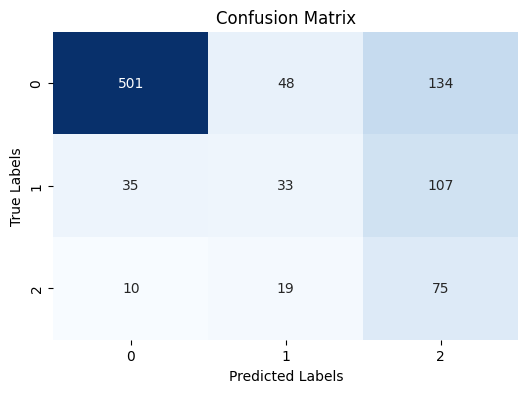


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 501/683 (73.35%)
Class 1: Correct Predictions / Total True Samples = 33/175 (18.86%)
Class 2: Correct Predictions / Total True Samples = 75/104 (72.12%)

Precision-Recall Curves:


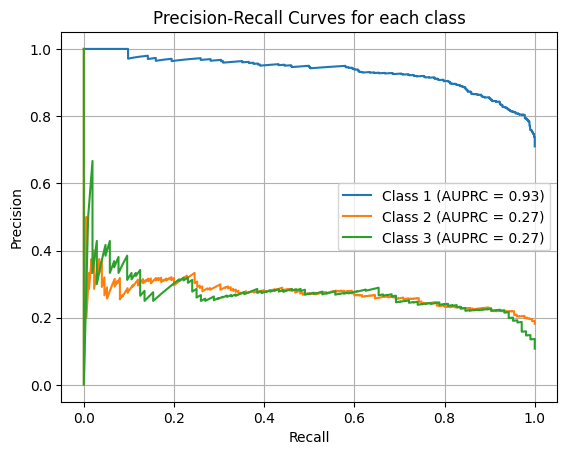


ROC Curves:


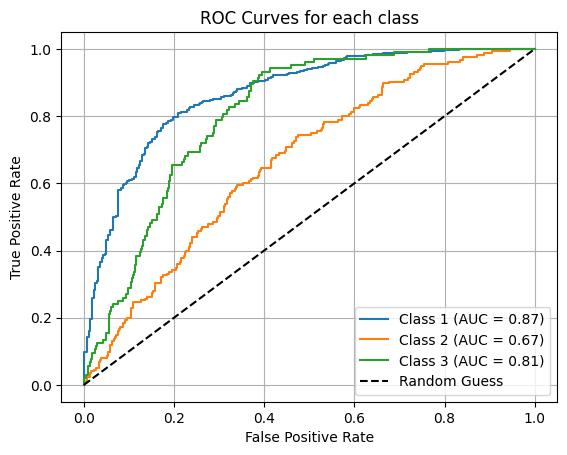


Mean F1 Score: 0.4708
Balanced Accuracy: 0.5478
Average AUPRC: 0.4913

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.73      0.82       683
           1       0.33      0.19      0.24       175
           2       0.24      0.72      0.36       104

    accuracy                           0.63       962
   macro avg       0.49      0.55      0.47       962
weighted avg       0.74      0.63      0.66       962

Accuracy for each fold: [np.float64(0.4568088809180542), np.float64(0.5411806002107956), np.float64(0.566690119525494), np.float64(0.5158996925473817), np.float64(0.54775127507924)]
AUPRC for each fold: [np.float64(0.46058368017998425), np.float64(0.5492179344142755), np.float64(0.5227831733410919), np.float64(0.5855319368594901), np.float64(0.4912834242052047)]
Average AUPRC across all folds: 0.5218800298000092
Average Balanced Accuracy across all folds: 0.5256661136561932
_____________________________________________

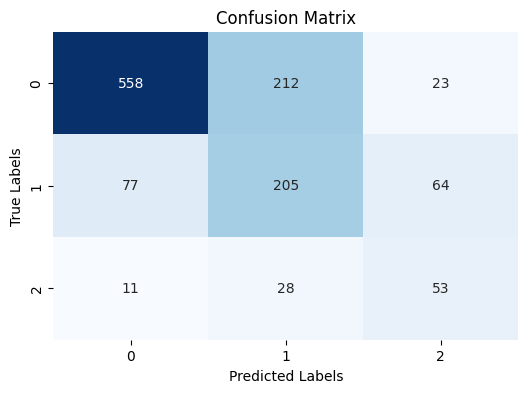


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 558/793 (70.37%)
Class 1: Correct Predictions / Total True Samples = 205/346 (59.25%)
Class 2: Correct Predictions / Total True Samples = 53/92 (57.61%)

Precision-Recall Curves:


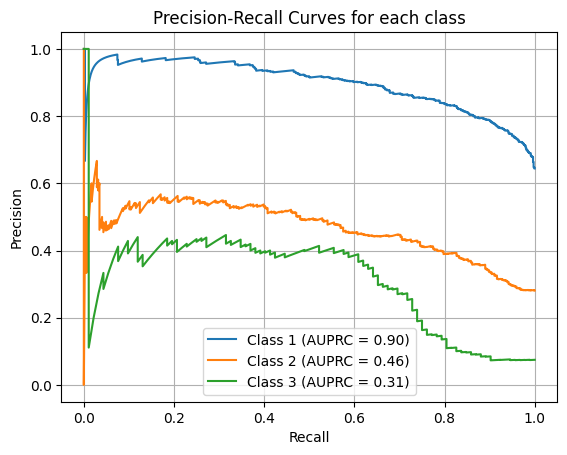


ROC Curves:


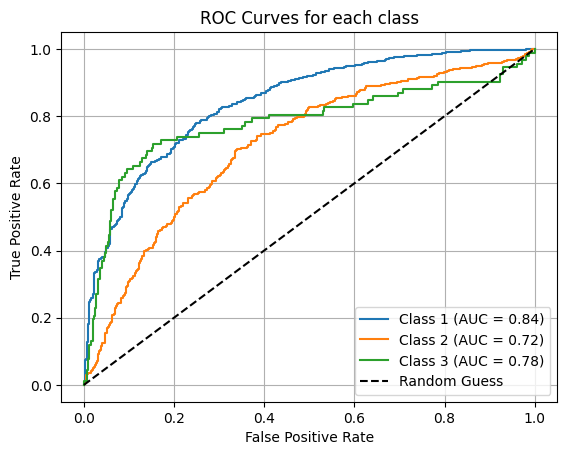


Mean F1 Score: 0.5836
Balanced Accuracy: 0.6241
Average AUPRC: 0.5579

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.70      0.78       793
           1       0.46      0.59      0.52       346
           2       0.38      0.58      0.46        92

    accuracy                           0.66      1231
   macro avg       0.57      0.62      0.58      1231
weighted avg       0.71      0.66      0.68      1231

Fold No: 2
Epoch [1/100], Loss: 1.1494, Accuracy: 0.3659
Validation Loss: 1.0527, Validation Accuracy: 0.3756
Epoch [2/100], Loss: 1.1024, Accuracy: 0.4073
Validation Loss: 1.1667, Validation Accuracy: 0.4136
Epoch [3/100], Loss: 1.0807, Accuracy: 0.4528
Validation Loss: 1.1369, Validation Accuracy: 0.4493
Epoch [4/100], Loss: 1.0534, Accuracy: 0.4943
Validation Loss: 0.9970, Validation Accuracy: 0.4656
Epoch [5/100], Loss: 1.0357, Accuracy: 0.5130
Validation Loss: 1.0484, Validation Accuracy: 0.4590
Epoch [6/100], Los

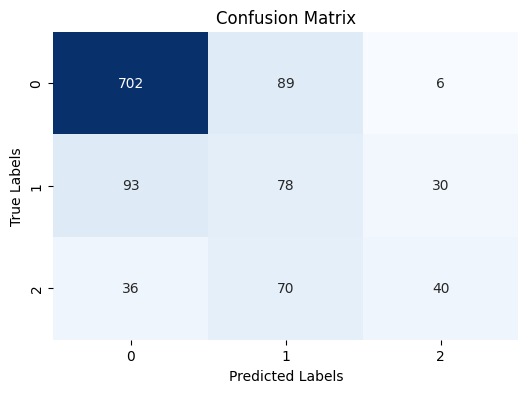


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 702/797 (88.08%)
Class 1: Correct Predictions / Total True Samples = 78/201 (38.81%)
Class 2: Correct Predictions / Total True Samples = 40/146 (27.40%)

Precision-Recall Curves:


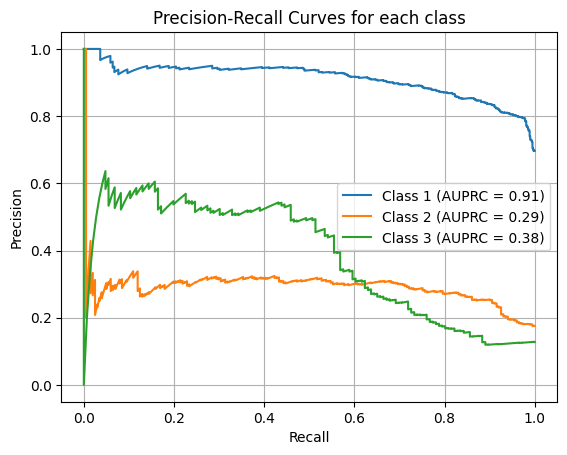


ROC Curves:


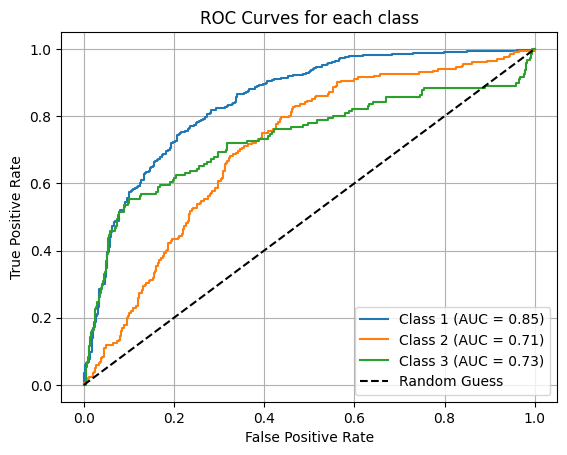


Mean F1 Score: 0.5263
Balanced Accuracy: 0.5143
Average AUPRC: 0.5273

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       797
           1       0.33      0.39      0.36       201
           2       0.53      0.27      0.36       146

    accuracy                           0.72      1144
   macro avg       0.57      0.51      0.53      1144
weighted avg       0.71      0.72      0.71      1144

Fold No: 3
Epoch [1/100], Loss: 1.1678, Accuracy: 0.3226
Validation Loss: 1.1316, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.1382, Accuracy: 0.3226
Validation Loss: 1.0303, Validation Accuracy: 0.3304
Epoch [3/100], Loss: 1.1281, Accuracy: 0.3665
Validation Loss: 1.1641, Validation Accuracy: 0.3404
Epoch [4/100], Loss: 1.0996, Accuracy: 0.3825
Validation Loss: 0.9393, Validation Accuracy: 0.4006
Epoch [5/100], Loss: 1.0661, Accuracy: 0.4840
Validation Loss: 0.9619, Validation Accuracy: 0.5424
Epoch [6/100], Los

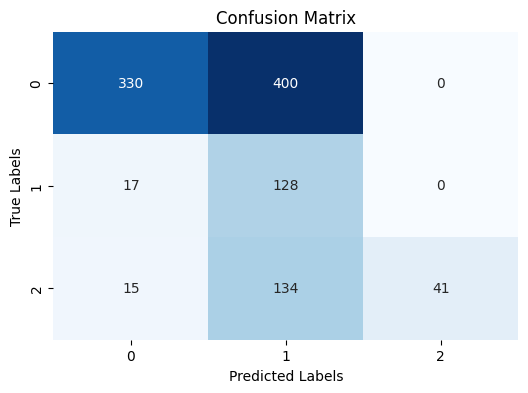


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 330/730 (45.21%)
Class 1: Correct Predictions / Total True Samples = 128/145 (88.28%)
Class 2: Correct Predictions / Total True Samples = 41/190 (21.58%)

Precision-Recall Curves:


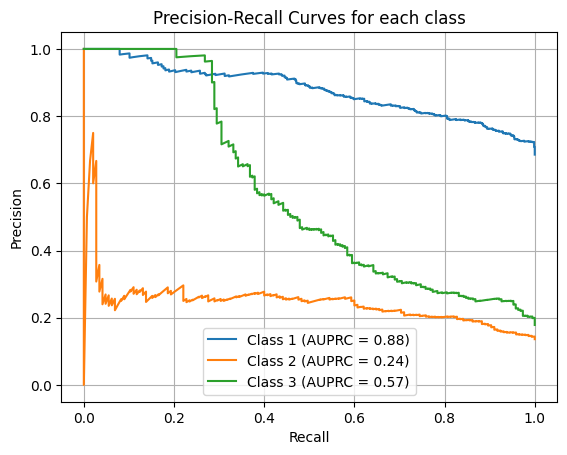


ROC Curves:


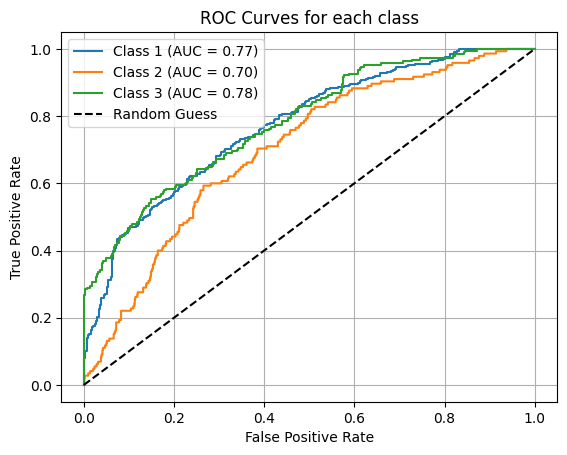


Mean F1 Score: 0.4255
Balanced Accuracy: 0.5169
Average AUPRC: 0.5632

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.45      0.60       730
           1       0.19      0.88      0.32       145
           2       1.00      0.22      0.35       190

    accuracy                           0.47      1065
   macro avg       0.70      0.52      0.43      1065
weighted avg       0.83      0.47      0.52      1065

Fold No: 4
Epoch [1/100], Loss: 1.1445, Accuracy: 0.3719
Validation Loss: 1.4192, Validation Accuracy: 0.3901
Epoch [2/100], Loss: 1.1048, Accuracy: 0.4049
Validation Loss: 0.9497, Validation Accuracy: 0.5053
Epoch [3/100], Loss: 1.0679, Accuracy: 0.4718
Validation Loss: 1.0569, Validation Accuracy: 0.5041
Epoch [4/100], Loss: 1.0637, Accuracy: 0.5056
Validation Loss: 1.0470, Validation Accuracy: 0.5952
Epoch [5/100], Loss: 1.0399, Accuracy: 0.5141
Validation Loss: 0.9549, Validation Accuracy: 0.5761
Epoch [6/100], Los

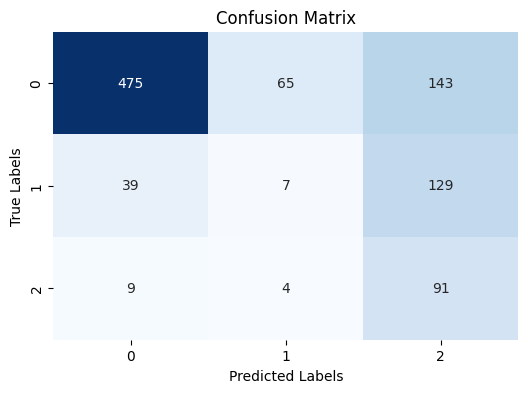


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 475/683 (69.55%)
Class 1: Correct Predictions / Total True Samples = 7/175 (4.00%)
Class 2: Correct Predictions / Total True Samples = 91/104 (87.50%)

Precision-Recall Curves:


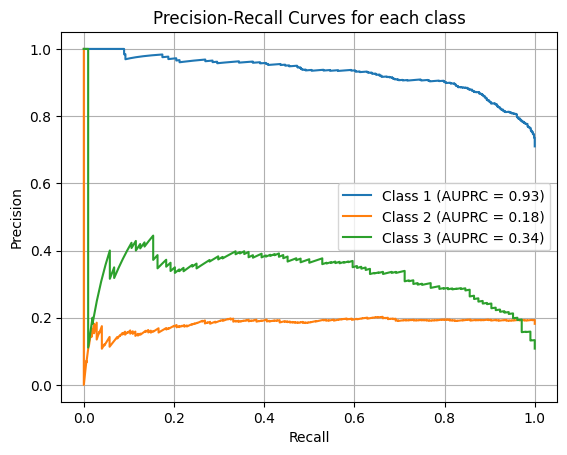


ROC Curves:


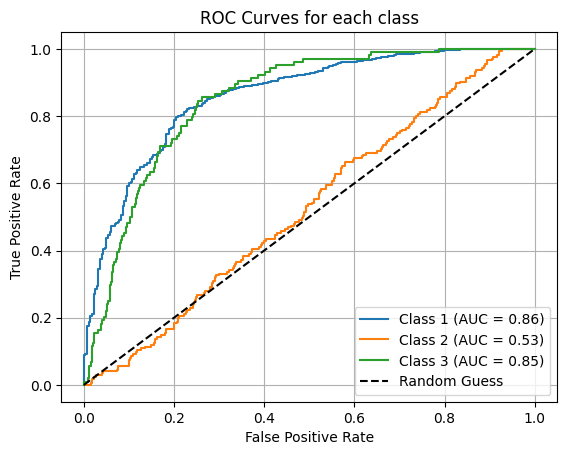


Mean F1 Score: 0.4111
Balanced Accuracy: 0.5368
Average AUPRC: 0.4829

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.70      0.79       683
           1       0.09      0.04      0.06       175
           2       0.25      0.88      0.39       104

    accuracy                           0.60       962
   macro avg       0.42      0.54      0.41       962
weighted avg       0.69      0.60      0.61       962

Fold No: 5
Epoch [1/100], Loss: 1.1449, Accuracy: 0.3707
Validation Loss: 1.3271, Validation Accuracy: 0.3518
Epoch [2/100], Loss: 1.0515, Accuracy: 0.5008
Validation Loss: 0.9358, Validation Accuracy: 0.4969
Epoch [3/100], Loss: 1.0434, Accuracy: 0.5296
Validation Loss: 0.9922, Validation Accuracy: 0.5621
Epoch [4/100], Loss: 0.9970, Accuracy: 0.5989
Validation Loss: 0.9314, Validation Accuracy: 0.5537
Epoch [5/100], Loss: 0.9709, Accuracy: 0.6192
Validation Loss: 0.9332, Validation Accuracy: 0.5412
Epoch [6/100], Los

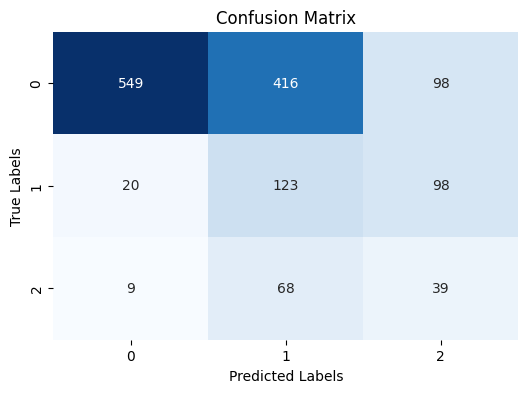


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 549/1063 (51.65%)
Class 1: Correct Predictions / Total True Samples = 123/241 (51.04%)
Class 2: Correct Predictions / Total True Samples = 39/116 (33.62%)

Precision-Recall Curves:


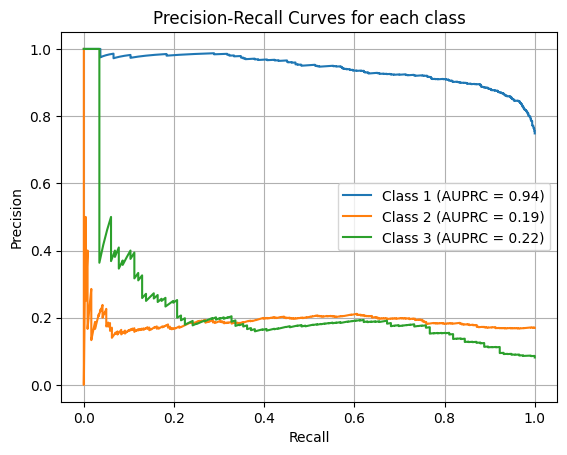


ROC Curves:


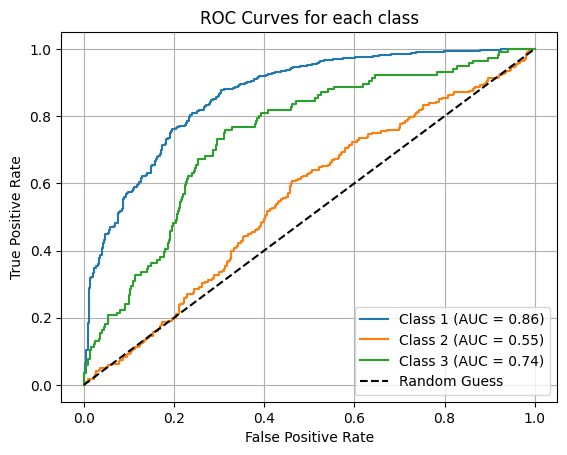


Mean F1 Score: 0.3938
Balanced Accuracy: 0.4543
Average AUPRC: 0.4500

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.52      0.67      1063
           1       0.20      0.51      0.29       241
           2       0.17      0.34      0.22       116

    accuracy                           0.50      1420
   macro avg       0.44      0.45      0.39      1420
weighted avg       0.76      0.50      0.57      1420

Accuracy for each fold: [np.float64(0.624076501464551), np.float64(0.5142784385082032), np.float64(0.5168676296314713), np.float64(0.5368204001952172), np.float64(0.4543477271837064)]
AUPRC for each fold: [np.float64(0.5578702678892722), np.float64(0.5273277814392027), np.float64(0.5631525466513775), np.float64(0.4829147947390576), np.float64(0.4499538676384112)]
Average AUPRC across all folds: 0.5162438516714642
Average Balanced Accuracy across all folds: 0.5292781393966297
____________________________________________

In [9]:
import pandas as pd
import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc






top_params = [
    {
        "trial": 26,
        "accuracy": 0.6503,
        "hyperparameters": {
            "ff_dim": 32,
            "dropout_rate": 0.4099952333473971,
            "embed_dim": 512,
            "learning_rate": 3.9184066289991565e-05,
            "optimizer": "Adam",
            "weight_decay": 2.0147478549329628e-05,
            "batch_size": 10,
            "num_heads": 8,
            "num_transformer_blocks": 8
        }
    },
    {
        "trial": 43,
        "accuracy": 0.6279,
        "hyperparameters": {
            "ff_dim": 32,
            "dropout_rate": 0.41853152648379743,
            "embed_dim": 1024,
            "learning_rate": 3.625518171447465e-07,
            "optimizer": "Adam",
            "weight_decay": 2.2825359494028837e-05,
            "batch_size": 10,
            "num_heads": 8,
            "num_transformer_blocks": 1
        }
    },
    {
        "trial": 47,
        "accuracy": 0.6158,
        "hyperparameters": {
            "ff_dim": 32,
            "dropout_rate": 0.18991275507279126,
            "embed_dim": 1024,
            "learning_rate": 3.4398216475610645e-07,
            "optimizer": "Adam",
            "weight_decay": 4.3924727014694645e-06,
            "batch_size": 10,
            "num_heads": 8,
            "num_transformer_blocks": 1
        }
    },
    {
        "trial": 33,
        "accuracy": 0.5895,
        "hyperparameters": {
            "ff_dim": 32,
            "dropout_rate": 0.4420138205390315,
            "embed_dim": 512,
            "learning_rate": 1.0832884746780947e-05,
            "optimizer": "Adam",
            "weight_decay": 3.9571476864810075e-05,
            "batch_size": 10,
            "num_heads": 8,
            "num_transformer_blocks": 1
        }
    },
    {
        "trial": 16,
        "accuracy": 0.5919,
        "hyperparameters": {
            "ff_dim": 32,
            "dropout_rate": 0.37836353824573477,
            "embed_dim": 512,
            "learning_rate": 3.461539792790534e-05,
            "optimizer": "Adam",
            "weight_decay": 0.0002545677491856814,
            "batch_size": 10,
            "num_heads": 8,
            "num_transformer_blocks": 8
        }
    }
]



for param_id in range(len(top_params)):
    # Fold indices and other configurations
    
    print(f"Running experiment with parameters:{param_id} {top_params[param_id]}")
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)    
    
    num_folds = 5
    fold_indices = np.random.permutation(np.arange(num_folds))
    val_fold_indices = np.roll(fold_indices, 1)

    test_folds_chosen = []
    val_folds_chosen = []
    fold_confusion_matrices = []  # To store confusion matrices for each fold
    fold_accuracies = []  # To store balanced accuracy for each fold
    fold_auprcs = []  # To store AUPRC for each fold

    # Model and training configurations
    num_classes = 3
    learning_rate = 0.0001
    epochs = 100
    input_shape = (3, 224, 224)  # (channels, height, width)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'




    embed_dim = top_params[param_id]["hyperparameters"]["embed_dim"]
    learning_rate = top_params[param_id]["hyperparameters"]["learning_rate"]
    num_heads = top_params[param_id]["hyperparameters"]["num_heads"]
    ff_dim = top_params[param_id]["hyperparameters"]["ff_dim"]
    num_transformer_blocks = top_params[param_id]["hyperparameters"]["num_transformer_blocks"]
    dropout_rate = top_params[param_id]["hyperparameters"]["dropout_rate"]
    batch_size = top_params[param_id]["hyperparameters"]["batch_size"]
    weight_decay = top_params[param_id]["hyperparameters"]["weight_decay"]
    print(f"Using parameters: embed_dim={embed_dim}, learning_rate={learning_rate}, num_heads={num_heads}, "
          f"ff_dim={ff_dim}, num_transformer_blocks={num_transformer_blocks}, dropout_rate={dropout_rate}, "
          f"batch_size={batch_size}, weight_decay={weight_decay}")

    # Training loop for cross-validation
    for fold_idx in range(num_folds):
        print(f'Fold No: {fold_idx + 1}')
        
        # Initialize model, loss, and optimizer
        fold_model = TransformerModel(input_shape=input_shape, num_classes=num_classes,
                                    embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim,
                                    num_transformer_blocks=num_transformer_blocks, dropout_rate=dropout_rate).to(device)

        
        criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
        optimizer = optim.Adam(fold_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        # Split data into train, validation, and test sets
        test_fold = fold_indices[fold_idx]
        val_fold = val_fold_indices[fold_idx]
        train_folds = [fold for fold in fold_indices if fold != test_fold and fold != val_fold]

        train_data = np.concatenate([eeg_folds[j] for j in train_folds])
        train_labels = np.concatenate([labels_folds[j] for j in train_folds])
        train_data = train_data.transpose(0, 3, 1, 2)  # Transpose to match PyTorch input format

        test_folds_chosen.append(test_fold)
        val_folds_chosen.append(val_fold)
        
        early_stopping = EarlyStopping(patience=10)
        
        # Training loop
        for epoch in range(epochs):
            balanced_train_data, balanced_train_labels = data_balancer(train_data, train_labels, factor=1)

            train_dataset = TensorDataset(
                torch.tensor(balanced_train_data, dtype=torch.float32).to(device),
                torch.tensor(balanced_train_labels, dtype=torch.long).to(device)
            )
            train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
            
            fold_model.train()
            running_loss = 0.0
            all_preds = []
            all_labels = []
            
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = fold_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = balanced_accuracy_score(all_labels, all_preds)
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

            # Validation loop
            val_data = eeg_folds[val_fold].transpose(0, 3, 1, 2)
            val_labels = labels_folds[val_fold]
            val_dataset = TensorDataset(
                torch.tensor(val_data, dtype=torch.float32).to(device),
                torch.tensor(val_labels, dtype=torch.long).to(device)
            )
            val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

            fold_model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels_list = []

            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_outputs = fold_model(val_inputs)
                    loss = criterion(val_outputs, val_labels)
                    val_loss += loss.item()

                    _, val_batch_preds = torch.max(val_outputs, 1)
                    val_preds.extend(val_batch_preds.cpu().numpy())
                    val_labels_list.extend(val_labels.cpu().numpy())

            val_loss /= len(val_loader)
            val_acc = balanced_accuracy_score(val_labels_list, val_preds)
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

            early_stopping(val_loss, fold_model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        # Load the best model
        early_stopping.load_best_model(fold_model)

        # Test loop
        test_data = eeg_folds[test_fold].transpose(0, 3, 1, 2)
        test_labels = labels_folds[test_fold]
        test_dataset = TensorDataset(
            torch.tensor(test_data, dtype=torch.float32).to(device),
            torch.tensor(test_labels, dtype=torch.long).to(device)
        )
        test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

        fold_model.eval()
        test_probs = []
        test_preds = []
        test_labels_list = []

        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_outputs = fold_model(test_inputs)
                probabilities = torch.softmax(test_outputs, dim=1)
                test_probs.extend(probabilities.cpu().numpy())
                _, preds = torch.max(probabilities, 1)
                test_preds.extend(preds.cpu().numpy())
                test_labels_list.extend(test_labels.cpu().numpy())

        # Compute metrics
        test_acc = balanced_accuracy_score(test_labels_list, test_preds)
        fold_accuracies.append(test_acc)

        cm = confusion_matrix(test_labels_list, test_preds)
        fold_confusion_matrices.append(cm)

        test_labels_binarized = label_binarize(test_labels_list, classes=np.arange(num_classes))
        test_auprcs = []
        for class_idx in range(num_classes):
            precision, recall, _ = precision_recall_curve(test_labels_binarized[:, class_idx], np.array(test_probs)[:, class_idx])
            auprc = auc(recall, precision)
            test_auprcs.append(auprc)

        mean_test_auprc = np.mean(test_auprcs)
        fold_auprcs.append(mean_test_auprc)

        print(f'Test Fold {fold_idx + 1}, Mean AUPRC: {mean_test_auprc:.4f}, Balanced Accuracy: {test_acc:.4f}')

        # Use the plot_metrics function to visualize metrics
        plot_metrics(np.array(test_labels_list), np.array(test_probs), n_classes=num_classes)

    # Final metrics across all folds
    average_auprc = np.mean(fold_auprcs)
    mean_accuracy = np.mean(fold_accuracies)
    print(f'Accuracy for each fold: {fold_accuracies}')
    print(f'AUPRC for each fold: {fold_auprcs}')
    print(f'Average AUPRC across all folds: {average_auprc}')
    print(f'Average Balanced Accuracy across all folds: {mean_accuracy}')
        
    # Save all results to CSV

    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print("_"*50)  